# Normalizing Flows for Astronomy

*Tutorial by Yuan-Sen Ting*

*Companion material for Chapter 15 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*

## Introduction

In our exploration of neural density estimators, we examined Mixture Density Networks, which parameterize probability distributions as weighted sums of Gaussian components. While MDNs provide considerable flexibility beyond deterministic predictions, they remain fundamentally constrained by their parametric assumptions. This limitation becomes particularly evident when modeling complex astronomical distributions—from the bimodal structure in stellar chemical abundance patterns to the intricate morphology of galaxy distributions in phase space.

Normalizing flows represent a paradigm shift in how we approach density estimation with neural networks. Rather than assuming a specific parametric form, these methods learn invertible transformations between simple base distributions (typically Gaussian) and arbitrarily complex target distributions. This approach maintains exact likelihood computation—essential for rigorous statistical inference—while offering unprecedented flexibility in modeling real astronomical data.

The power of this approach becomes clear when we consider the chemical abundance patterns observed in stellar populations. The distribution of stars in chemical abundance space reveals distinct populations with complex boundaries and correlations that defy simple parametric description. Traditional approaches force us to choose between oversimplified models that miss important structure or overparameterized models that risk overfitting. Normalizing flows elegantly sidestep this dilemma by learning the transformation that best captures the data's complexity without imposing restrictive assumptions.

This tutorial develops normalizing flows from first principles, implementing a complete RealNVP (Real-valued Non-Volume Preserving) architecture. Through analysis of APOGEE survey data, we demonstrate how these methods capture complex distributions while maintaining the mathematical rigor required for scientific applications. The techniques we develop here extend naturally to higher dimensions and form the foundation for modern simulation-based inference approaches in astronomy.

## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Deep Learning Fundamentals**: Understanding of neural networks, backpropagation, and PyTorch basics from previous tutorials
- **Probability Theory**: Comfort with probability distributions, change of variables formula, and likelihood functions
- **Maximum Likelihood Estimation**: Experience with MLE for parameter estimation and loss function optimization
- **Linear Algebra**: Understanding of matrix operations, determinants, and Jacobian matrices

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Change of Variables**: Understanding how probability distributions transform under invertible mappings and the role of the Jacobian
- **Neural Architecture Design**: Building neural networks that satisfy mathematical constraints (invertibility and tractable Jacobians)
- **Likelihood-Free Inference**: Learning complex distributions without assuming parametric forms
- **Implementation Skills**: Constructing a complete normalizing flow from scratch using PyTorch
- **Scientific Application**: Applying these methods to real astronomical data and interpreting results in physical context

We begin by importing the necessary libraries and establishing our computational environment:

In [1]:
# Display matplotlib plots inline in the Jupyter notebook
%matplotlib inline

# Import necessary packages
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# Configure plotting parameters
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Define the value of Pi for PyTorch
torch_pi = 3.1415916

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Maximum Likelihood Estimation and Its Limitations

Throughout this course, we have relied on maximum likelihood estimation as a cornerstone of statistical inference. When we know the parametric form of a distribution, MLE provides a principled approach to parameter estimation by finding values that maximize the probability of observing our data. The elegance of this method, combined with PyTorch's automatic differentiation capabilities, makes even complex optimization problems tractable.

Let us begin by reviewing how MLE works for a known parametric distribution. PyTorch's `torch.distributions` module provides a convenient interface for working with probability distributions. Consider a simple Gaussian distribution:

In [2]:
# Create a tensor with the mean of the Gaussian distribution
mu_truth = torch.tensor([3.0])

# Create a tensor with the standard deviation of the Gaussian distribution
sigma_truth = torch.tensor([5.0]) 

# Create an instance of the Gaussian distribution with the given mean and standard deviation
normal_distribution = torch.distributions.normal.Normal(loc=mu_truth, scale=sigma_truth)

The distribution instance provides two essential capabilities. First, we can sample from it to generate synthetic data. Second, we can evaluate the log-probability of any given value, which forms the basis of likelihood computation:

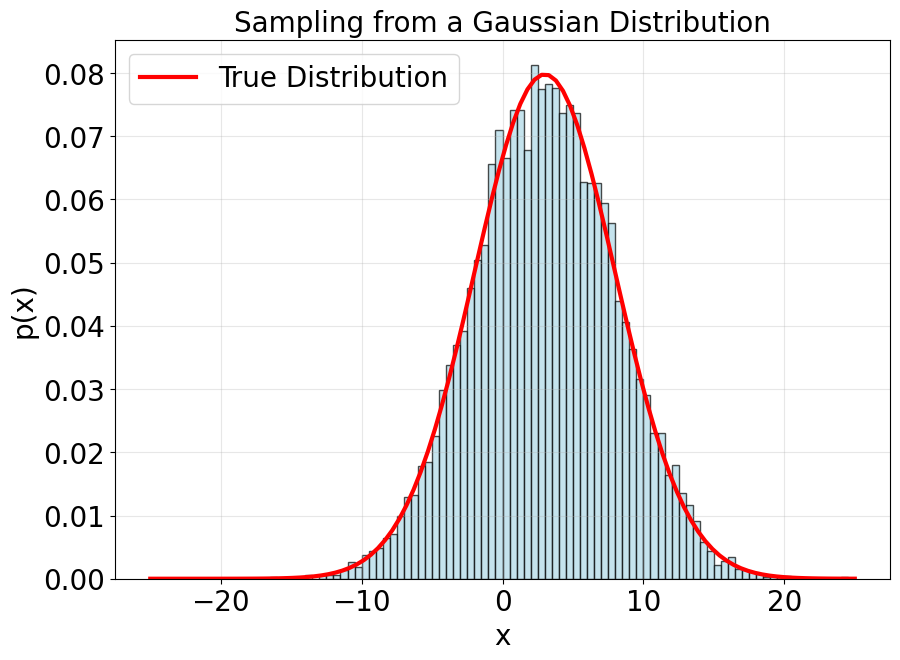

In [3]:
# Draw 10000 samples from the Gaussian distribution using the `sample` method of the distribution instance
x_torch = normal_distribution.sample(torch.Size([10000]))

# Create a histogram of the samples, using 100 bins from -25 to 25, and normalized by the total number of samples
plt.figure(figsize=(10, 7))
plt.hist(x_torch.numpy(), bins=100, range=[-25,25], density=True, alpha=0.7, color='lightblue', edgecolor='black')

# Generate a range of x values from -25 to 25 using `torch.linspace`
x_range = torch.linspace(-25,25,100)

# Evaluate the Gaussian distribution probability density function at each value in the `x_range` using the `log_prob` method and exponentiating the result
y_prob = torch.exp(normal_distribution.log_prob(x_range))

# Plot the resulting probability density function curve on top of the histogram
plt.plot(x_range, y_prob, linewidth=3, color='red', label='True Distribution')

# Label the x-axis as "x" and the y-axis as "p(x)"
plt.xlabel("x")
plt.ylabel("p(x)")
plt.title("Sampling from a Gaussian Distribution")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

MLE seeks to find parameters that maximize the likelihood of observing our data. The method assumes a parametric form of the distribution, i.e., $p(\mathbf{x}) = p(\mathbf{x}|\boldsymbol{\theta})$, where $\boldsymbol{\theta}$ is the parameter that governs the distribution. MLE asserts that the optimal estimate of the parameter $\boldsymbol{\theta}$ that describes the data $\{\mathbf{x}_i\}$ is the one that maximizes the likelihood function:

$$\boldsymbol{\theta}_{\rm optimal} = \arg\max_{\boldsymbol{\theta}} \prod_i p(\mathbf{x}_i|\boldsymbol{\theta})$$

This formula calculates the optimal value of the parameter $\boldsymbol{\theta}$ by finding the maximum value of the likelihood function, which is the product of the probabilities of observing each data point given the parameter $\boldsymbol{\theta}$. Intuitively, we seek the probability distribution that "envelopes" the data—the one that makes the observed data as likely as possible.

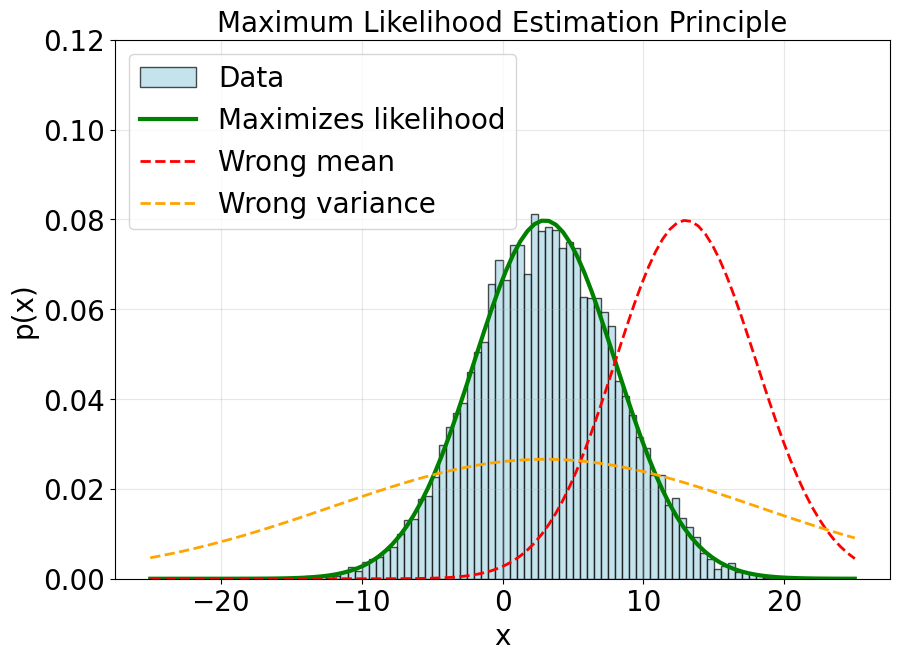

In [4]:
# Draw from the distribution
plt.figure(figsize=(10, 7))
plt.hist(x_torch.numpy(), bins=100, range=[-25,25], density=True, alpha=0.7, color='lightblue', edgecolor='black', label='Data')

# The correct distribution should "envelope" the data
x_range = torch.linspace(-25,25,100)
y_prob = torch.exp(normal_distribution.log_prob(x_range))
plt.plot(x_range, y_prob, lw=3, label="Maximizes likelihood", color='green')

# If we use the wrong mu and sigma, the likelihood will be worse
normal_wrong = torch.distributions.normal.Normal(loc=mu_truth+10., scale=sigma_truth)
y_prob = torch.exp(normal_wrong.log_prob(x_range))
plt.plot(x_range, y_prob, color="red", ls="--", lw=2, label="Wrong mean")

normal_wrong = torch.distributions.normal.Normal(loc=mu_truth, scale=sigma_truth*3.)
y_prob = torch.exp(normal_wrong.log_prob(x_range))
plt.plot(x_range, y_prob, color="orange", ls="--", lw=2, label="Wrong variance")

plt.legend()
plt.ylim([0,0.12]) 
plt.xlabel("x") 
plt.ylabel("p(x)")
plt.title("Maximum Likelihood Estimation Principle")
plt.grid(True, alpha=0.3)
plt.show()

The autodifferentiation functionality of PyTorch makes it an excellent tool for solving optimization problems, including the classical MLE problem. We can use PyTorch to recover the Gaussian distribution parameters from observed data by minimizing the negative log-likelihood:

$$\boldsymbol{\theta}_{\rm optimal} = \arg\min_{\boldsymbol{\theta}} \left( - \sum_i \log p(\mathbf{x}_i|\boldsymbol{\theta}) \right)$$

For a Gaussian distribution, the log-likelihood has an analytical form:

$$\log p(\mathbf{x}_i | \mu, \sigma) = -0.5 \log \big( 2 \pi \sigma^2 \big) - \frac{(\mathbf{x}_i-\mu)^2}{2\sigma^2}$$

To implement this in PyTorch, we define the negative log-likelihood as a loss function and use gradient descent to find the optimal parameters:

In [5]:
def loss_fn(x, mu, sigma):
    log_prob = -0.5 * torch.log(2 * np.pi * sigma**2) - (x - mu)**2 / (2 * sigma**2)
    return -log_prob.mean()

# Define parameters to optimize
sigma = nn.Parameter(torch.rand(1, requires_grad=True))
mu = nn.Parameter(torch.rand(1, requires_grad=True))

# Define learning rate and optimizer
lr = 0.01
params = [sigma, mu]
optimiser = torch.optim.Adam(params, lr=lr)

In [6]:
# Set the number of epochs for training
num_epochs = 20000

# Loop over the number of epochs
for epoch in range(num_epochs):
    
    # Reset the gradients to zero
    optimiser.zero_grad()
    
    # Compute the negative log-likelihood loss
    loss = loss_fn(x_torch, mu, sigma)
    
    # Compute the gradients of the loss with respect to the parameters
    loss.backward()
    
    # Update the parameters based on the gradients and the optimizer
    optimiser.step()

    # Print the training loss every 1000 epochs
    if epoch % 1000 == 0:
        print('iter %s:' % epoch, 'training loss = %.5f' % loss)

# Print the best estimated sigma and mean
print("\nBest estimated sigma:", sigma.detach().numpy()[0])
print("Best estimate mean:", mu.detach().numpy()[0])
print("\nTrue sigma:", sigma_truth.numpy()[0])
print("True mean:", mu_truth.numpy()[0])

iter 0: training loss = 29.20375
iter 1000: training loss = 3.51448
iter 2000: training loss = 3.16282
iter 3000: training loss = 3.07075
iter 4000: training loss = 3.04194
iter 5000: training loss = 3.03420
iter 6000: training loss = 3.03287
iter 7000: training loss = 3.03278
iter 8000: training loss = 3.03278
iter 9000: training loss = 3.03278
iter 10000: training loss = 3.03278
iter 11000: training loss = 3.03278
iter 12000: training loss = 3.03278
iter 13000: training loss = 3.03278
iter 14000: training loss = 3.03278
iter 15000: training loss = 3.03278
iter 16000: training loss = 3.03278
iter 17000: training loss = 3.03278
iter 18000: training loss = 3.03278
iter 19000: training loss = 3.03278

Best estimated sigma: 5.022046
Best estimate mean: 3.0321975

True sigma: 5.0
True mean: 3.0


The outcome of our PyTorch optimization process closely resembles the actual distribution, with small discrepancies arising from finite sampling noise—an inevitable aspect of statistical inference. To reduce this noise and obtain more accurate estimates, we would need to increase the number of samples, analogous to how obtaining deeper astronomical surveys reduces statistical uncertainties.

Thus far, we manually derived the expression for the logarithm of the Gaussian distribution. While instructive, PyTorch's `torch.distributions` module provides convenient methods for working with common distributions, which we'll leverage as we extend to more complex cases.

## Extension to Multivariate Gaussian MLE

So far, we have demonstrated how to use MLE to estimate the parameters of a 1D Gaussian distribution. The concept extends naturally to multivariate Gaussian distributions, where we must estimate both a mean vector and a covariance matrix.

In the multivariate case, the probability density function is defined over a vector $\mathbf{x} \in \mathbb{R}^D$ of $D$-dimensional data points. The multivariate Gaussian distribution is characterized by a $D$-dimensional mean vector $\boldsymbol{\mu} \in \mathbb{R}^D$ and a $D \times D$ covariance matrix $\boldsymbol{\Sigma}$:

$$ p(\mathbf{x} | \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{(2 \pi)^{D/2} |\boldsymbol{\Sigma}|^{1/2}} \exp \left(- \frac{1}{2} (\mathbf{x}-\boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x}-\boldsymbol{\mu}) \right) $$

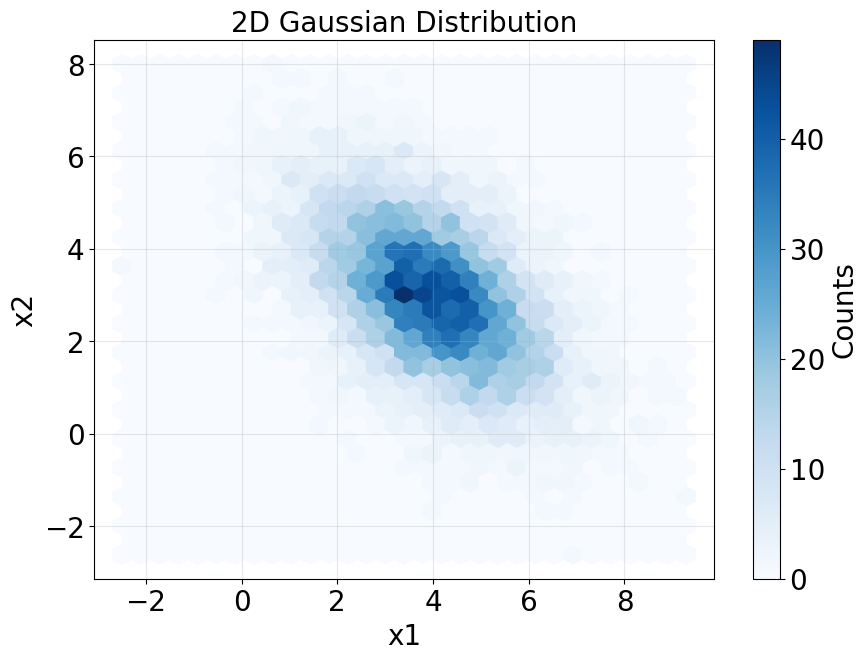

In [7]:
# Define the ground truth mean and covariance matrix
mu_truth = torch.tensor([4.0, 3.0])
cov_truth = torch.tensor([[2., -1.], [-1., 2.]])

# Define the instance and draw from the instance
normal_distribution = torch.distributions.multivariate_normal.MultivariateNormal(
    loc=mu_truth, covariance_matrix=cov_truth)
x_torch = normal_distribution.sample(sample_shape=torch.Size([10000]))

# Visualize the distribution
plt.figure(figsize=(10, 7))
plt.hexbin(x_torch[:, 0].numpy(), x_torch[:, 1].numpy(), bins=50, cmap="Blues", gridsize=30)
plt.colorbar(label='Counts')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("2D Gaussian Distribution")
plt.grid(True, alpha=0.3)
plt.show()

In the 2D case, optimizing the covariance matrix $\boldsymbol{\Sigma}$ directly can be unstable due to constraints—the matrix must remain positive definite throughout optimization. To ensure numerical stability, we parameterize $\boldsymbol{\Sigma} = \mathbf{M} \mathbf{M}^T$, where $\mathbf{M}$ is a free parameter matrix. This Cholesky-like decomposition guarantees that $\boldsymbol{\Sigma}$ remains positive definite while allowing unconstrained optimization of $\mathbf{M}$.

The log-likelihood for a multivariate Gaussian becomes:

$$\log p(\mathbf{x}|\mathbf{M}) = -\frac{D}{2}\log(2\pi) - \log|\mathbf{M}| - \frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T (\mathbf{M}\mathbf{M}^T)^{-1} (\mathbf{x}-\boldsymbol{\mu})$$

This reparameterization trick proves invaluable for many optimization problems involving covariance matrices, ensuring stable convergence while maintaining mathematical validity.

In [8]:
# Define the parameters for optimization
# Sigma = M@M.T
M = nn.Parameter(torch.randn(2,2, requires_grad=True))  # Initialize the matrix M
mu = nn.Parameter(torch.randn(2, requires_grad=True))  # Initialize the mean mu

# Optimizer
lr = 0.01
params = [M, mu]
optimiser = torch.optim.Adam(params, lr=lr)  # Define the optimizer

# Optimizing through maximizing the log likelihood
def loss_fn(sample):
    # Calculate the log-likelihood by substituting Sigma with M@M^T and using matrix operations
    log_prob = -torch.log(torch.sqrt((2*torch_pi)**2*torch.det(M@M.T))) \
             - 0.5*torch.sum(((sample-mu)@torch.inverse(M@M.T))*(sample-mu), axis=1)
    
    return -torch.mean(log_prob)  # Return the negative mean log-likelihood

In [9]:
num_epochs = 20000

for e in range(num_epochs):
    loss = loss_fn(x_torch)
    optimiser.zero_grad()  # Zero the gradients
    loss.backward()  # Compute gradients
    optimiser.step()  # Update the parameters

    if e % 1000 == 0:
        print('iter %s:' % e, 'training loss = %.5f' % loss)

# Print the best estimated covariance matrix and mean
print("\nBest estimated covariance matrix:")
print((M@M.T).detach().numpy())
print("Best estimated mean:", mu.detach().numpy())

print("\nTrue covariance matrix:")
print(cov_truth.numpy())
print("True mean:", mu_truth.numpy())

iter 0: training loss = 43.83421
iter 1000: training loss = 3.55966
iter 2000: training loss = 3.38905
iter 3000: training loss = 3.38886
iter 4000: training loss = 3.38886
iter 5000: training loss = 3.38886
iter 6000: training loss = 3.38886
iter 7000: training loss = 3.38886
iter 8000: training loss = 3.38886
iter 9000: training loss = 3.38886
iter 10000: training loss = 3.38886
iter 11000: training loss = 3.38886
iter 12000: training loss = 3.38886
iter 13000: training loss = 3.38886
iter 14000: training loss = 3.38886
iter 15000: training loss = 3.38886
iter 16000: training loss = 3.38886
iter 17000: training loss = 3.38886
iter 18000: training loss = 3.38886
iter 19000: training loss = 3.38886

Best estimated covariance matrix:
[[ 2.0116134 -1.0023016]
 [-1.0023016  1.9950978]]
Best estimated mean: [3.9966888 2.9907281]

True covariance matrix:
[[ 2. -1.]
 [-1.  2.]]
True mean: [4. 3.]


The estimated mean and covariance matrix closely match their ground truth values, validating our optimization approach. To visualize how well our model has learned the distribution, we can generate samples from the estimated parameters and compare them with the original data:

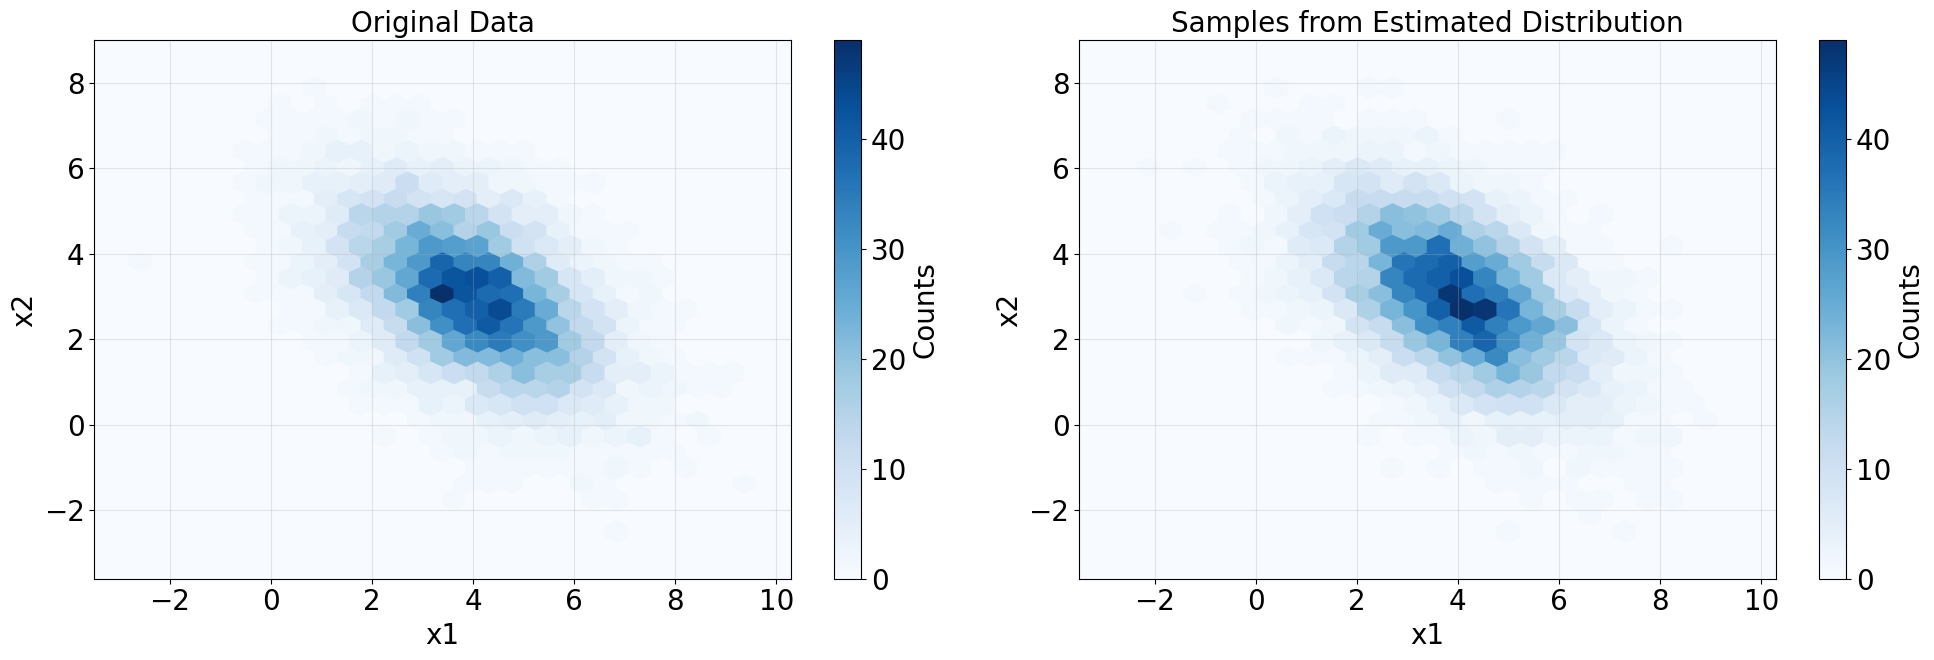

In [10]:
# Define the multivariate normal distribution using the estimated mean and covariance matrix
normal_pred = torch.distributions.multivariate_normal.MultivariateNormal(
    loc=mu, covariance_matrix=M@M.T)

# Draw samples from the distribution and visualize the result
x_test = normal_pred.sample(sample_shape=torch.Size([10000]))

# Calculate axis limits to ensure both plots have the same range
x_min = min(x_torch[:,0].numpy().min(), x_test[:,0].detach().numpy().min()) - 1
x_max = max(x_torch[:,0].numpy().max(), x_test[:,0].detach().numpy().max()) + 1
y_min = min(x_torch[:,1].numpy().min(), x_test[:,1].detach().numpy().min()) - 1
y_max = max(x_torch[:,1].numpy().max(), x_test[:,1].detach().numpy().max()) + 1

# Plot side by side comparison
plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
plt.hexbin(x_torch[:,0].numpy(), x_torch[:,1].numpy(), 
           bins=50, cmap="Blues", gridsize=30, extent=[x_min, x_max, y_min, y_max])
plt.colorbar(label='Counts')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Original Data")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hexbin(x_test[:,0].detach().numpy(), x_test[:,1].detach().numpy(), 
           bins=50, cmap="Blues", gridsize=30, extent=[x_min, x_max, y_min, y_max])
plt.colorbar(label='Counts')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Samples from Estimated Distribution")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## The Limitation of Parametric Maximum Likelihood Estimation

In parametric maximum likelihood estimation, we assume prior knowledge of the parametric form of a distribution that describes the data. While this approach works well for simple cases, astronomical data often exhibits complex structures that defy simple parametric description. The true challenge arises when there is no good parametric form that adequately captures the distribution of the data.

To illustrate this limitation, we'll analyze the APOGEE dataset, which provides precise chemical abundance measurements for thousands of stars in our Galaxy. The distribution of stars in chemical abundance space reveals fundamental insights about galactic evolution that cannot be captured by simple parametric models.

The notation [X/Y] represents the logarithmic abundance ratio between elements X and Y relative to the Sun. Specifically, [Fe/H] measures the iron abundance relative to hydrogen compared to solar values:

$$[\text{Fe/H}] = \log_{10}\left(\frac{N_{\text{Fe}}}{N_{\text{H}}}\right)_{\star} - \log_{10}\left(\frac{N_{\text{Fe}}}{N_{\text{H}}}\right)_{\odot}$$

where $N$ denotes the number density of atoms. A star with [Fe/H] = 0 has solar iron abundance, while [Fe/H] = -1 indicates ten times less iron than the Sun.

Alpha elements (O, Mg, Si, S, Ca, Ti) are produced primarily in massive stars through alpha particle (helium nucleus) capture. These elements are released into the interstellar medium through core-collapse supernovae on short timescales (~10 Myr). In contrast, iron is produced significantly in both core-collapse supernovae and Type Ia supernovae, with the latter occurring on much longer timescales (~1 Gyr).

This difference in production timescales creates a cosmic clock. The [α/Fe] ratio traces the star formation history of the Galaxy: high [α/Fe] indicates rapid star formation where only core-collapse supernovae had time to enrich the gas, while low [α/Fe] suggests extended star formation where Type Ia supernovae contributed significant iron. The distribution of stars in [α/Fe]-[Fe/H] space thus reveals distinct populations formed during different phases of galactic evolution—a complex, multi-modal structure that emerges from astrophysical processes rather than statistical randomness.

Data shape: torch.Size([23986, 13])
Number of stars: 23986
Number of abundances: 13
Abundances: ['mgh', 'oh', 'sih', 'sh', 'cah', 'nah', 'alh', 'kh', 'crh', 'feh', 'nih', 'vh', 'coh']


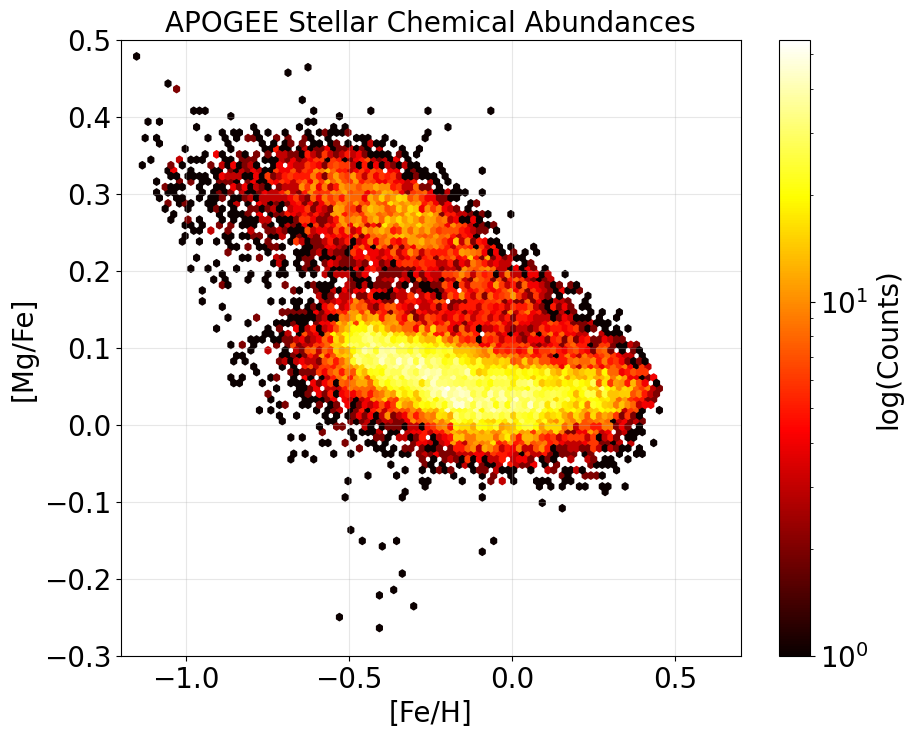

In [11]:
# Load the preprocessed abundances
data = np.load('dataset_apogee_abundances.npz')

# Stack all abundances into a single array
abundances = []
abundance_names = []
for key in ['mgh', 'oh', 'sih', 'sh', 'cah', 'nah', 'alh', 
            'kh', 'crh', 'feh', 'nih', 'vh', 'coh']:
    abundances.append(data[key])
    abundance_names.append(key)

x_numpy = np.column_stack(abundances)
x_torch = torch.tensor(x_numpy, dtype=torch.float32)

print(f"Data shape: {x_torch.shape}")
print(f"Number of stars: {x_torch.shape[0]}")
print(f"Number of abundances: {x_torch.shape[1]}")
print(f"Abundances: {abundance_names}")

# Find indices for Mg/H and Fe/H for visualization
mgh_idx = abundance_names.index('mgh')
feh_idx = abundance_names.index('feh')

# Visualize the data using a finer 2D hexbin plot
plt.figure(figsize=(10, 8))
plt.hexbin(x_torch[:, feh_idx].numpy(), 
           x_torch[:, mgh_idx].numpy() - x_torch[:, feh_idx].numpy(), 
           bins='log', cmap="hot", gridsize=100, mincnt=1)
cbar = plt.colorbar(label='log(Counts)')
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
plt.title("APOGEE Stellar Chemical Abundances")
plt.xlim(-1.2, 0.7)
plt.ylim(-0.3, 0.5)
plt.grid(True, alpha=0.3)
plt.show()

The complex structure visible in this distribution—with its distinct populations and curved boundaries—immediately suggests that a simple Gaussian model will be inadequate. Nevertheless, let's attempt to fit a 2D Gaussian to the [Fe/H]-[Mg/Fe] projection to quantify exactly how parametric approaches fail:

In [12]:
# Extract just the 2D projection for this demonstration
x_2d = torch.stack([x_torch[:, feh_idx], 
                    x_torch[:, mgh_idx] - x_torch[:, feh_idx]], dim=1)

# Define the parameters for optimization
# Sigma = M@M^T
M = nn.Parameter(torch.randn(2,2, requires_grad=True))
mu = nn.Parameter(torch.randn(2, requires_grad=True))

# Optimizer
lr = 0.01
params = [M, mu]
optimiser = torch.optim.Adam(params, lr=lr)

# Optimizing through maximizing the log likelihood
def loss_fn(sample):
    log_prob = -torch.log(torch.sqrt((2*torch_pi)**2*torch.det(M@M.T))) \
             - 0.5*torch.sum(((sample-mu)@torch.inverse(M@M.T))*(sample-mu), axis=1)
    return -torch.mean(log_prob)

# Training loop
num_epochs = 20000

for e in range(num_epochs):
    loss = loss_fn(x_2d)
    optimiser.zero_grad()
    loss.backward(retain_graph=True)
    optimiser.step()
        
    if e % 1000 == 0:
        print('iter %s:' % e, 'training loss = %.5f' % loss)

iter 0: training loss = 6.20302
iter 1000: training loss = -1.03602
iter 2000: training loss = -1.03602
iter 3000: training loss = -1.03602
iter 4000: training loss = -1.03602
iter 5000: training loss = -1.03602
iter 6000: training loss = -1.03602
iter 7000: training loss = -1.03602
iter 8000: training loss = -1.03602
iter 9000: training loss = -1.03580
iter 10000: training loss = -1.03546
iter 11000: training loss = -1.03602
iter 12000: training loss = -1.03597
iter 13000: training loss = -1.03596
iter 14000: training loss = -1.03598
iter 15000: training loss = -1.03602
iter 16000: training loss = -1.03602
iter 17000: training loss = -1.03598
iter 18000: training loss = -1.03602
iter 19000: training loss = -1.03601


To visualize how poorly our Gaussian model captures the true distribution, we'll compare samples from our fitted model with the actual APOGEE data:

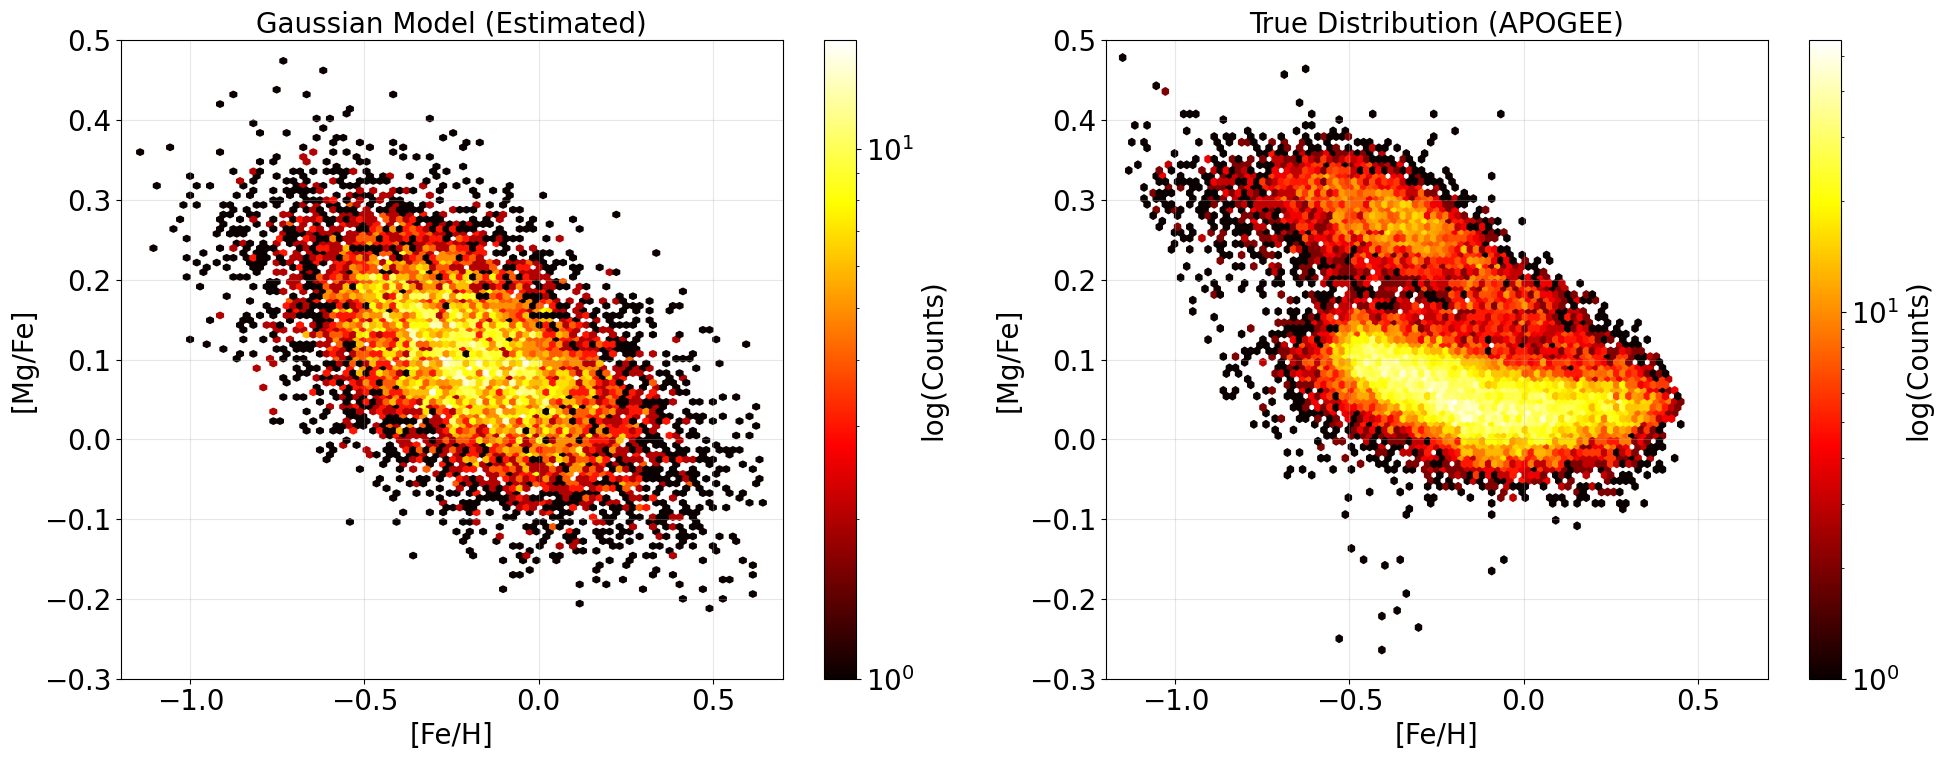

In [13]:
# The best fit model
normal_pred = torch.distributions.multivariate_normal.MultivariateNormal(
    loc=mu, covariance_matrix=M@M.T)
x_test = normal_pred.sample(sample_shape=torch.Size([10000]))

plt.figure(figsize=(20, 8))

# Plot estimated distribution
plt.subplot(1, 2, 1)
plt.hexbin(x_test[:,0].detach().numpy(), x_test[:,1].detach().numpy(), 
           bins='log', cmap="hot", gridsize=100, mincnt=1)
plt.colorbar(label='log(Counts)')
plt.ylim([-0.3,0.5])
plt.xlim([-1.2,0.7])
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
plt.title("Gaussian Model (Estimated)")
plt.grid(True, alpha=0.3)

# Plot ground truth distribution
plt.subplot(1, 2, 2)
plt.hexbin(x_2d[:,0].numpy(), x_2d[:,1].numpy(), 
           bins='log', cmap="hot", gridsize=100, mincnt=1)
plt.colorbar(label='log(Counts)')
plt.ylim([-0.3,0.5])
plt.xlim([-1.2,0.7])
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
plt.title("True Distribution (APOGEE)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The Gaussian distribution fails spectacularly to capture the underlying structure. While it correctly identifies the mean location, it completely misses the bimodal nature and the characteristic "banana-shaped" distribution of the high-α and low-α sequences. 

To improve our model, we might consider a Gaussian Mixture Model (GMM) with multiple components. Let's try fitting a mixture of two Gaussians:

$$p(\mathbf{x} | \boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1, \boldsymbol{\mu}_2, \boldsymbol{\Sigma}_2, w_1) = w_1 \mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1) + (1-w_1) \mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_2, \boldsymbol{\Sigma}_2)$$

where $w_1$ is the weight of the first component and $(1-w_1)$ is the weight of the second component.

In [14]:
# Define the parameters that we want to optimize
# Note: by definition w2 = 1-w1, hence we only need to optimize w1
M1 = nn.Parameter(torch.randn(2,2, requires_grad=True)*0.1)  # First covariance matrix
mu1 = nn.Parameter(torch.tensor([0.,0.]), requires_grad=True)  # First mean vector
M2 = nn.Parameter(torch.randn(2,2, requires_grad=True)*0.1)  # Second covariance matrix
mu2 = nn.Parameter(torch.tensor([-0.5,0.3]), requires_grad=True)  # Second mean vector
w1 = nn.Parameter(torch.rand(1, requires_grad=True))  # Weight for first Gaussian

# Define optimizer
lr = 0.01  # Learning rate
params = [M1, mu1, M2, mu2, w1]  # List of parameters to optimize
optimiser = torch.optim.Adam(params, lr=lr)  # Adam optimizer with given learning rate

# The loss function
def loss_fn(sample):
    # We take the log-likelihood for individual Gaussians, weighted by the weight, w1
    log_prob1 = torch.log(w1) - torch.log(torch.sqrt((2*torch_pi)**2*torch.det(M1@M1.T))) \
             - 0.5*torch.sum(((sample-mu1)@torch.inverse(M1@M1.T))*(sample-mu1), axis=1)
    log_prob2 = torch.log((1-w1)) - torch.log(torch.sqrt((2*torch_pi)**2*torch.det(M2@M2.T))) \
             - 0.5*torch.sum(((sample-mu2)@torch.inverse(M2@M2.T))*(sample-mu2), axis=1)
    
    # The total likelihood is the logarithm of the sum of the exponential of these two terms
    # This process can be numerically unstable if not done correctly
    # Luckily, torch.logsumexp takes care of all the numerical instability issues
    log_prob_all = torch.stack([log_prob1,log_prob2])
    log_prob = torch.logsumexp(log_prob_all,dim=0)
    return -torch.mean(log_prob)

In [15]:
num_epochs = 20000

for e in range(num_epochs):
    loss = loss_fn(x_2d)
    optimiser.zero_grad()
    loss.backward(retain_graph=True)
    optimiser.step()
        
    if e % 1000 == 0:
        print('iter %s:' % e, 'training loss = %.5f' % loss)

print(f"\nFinal weights: w1 = {w1.detach().numpy()[0]:.3f}, w2 = {(1-w1).detach().numpy()[0]:.3f}")

iter 0: training loss = 0.51902
iter 1000: training loss = -1.30389
iter 2000: training loss = -1.30389
iter 3000: training loss = -1.30386
iter 4000: training loss = -1.30383
iter 5000: training loss = -1.30375
iter 6000: training loss = -1.30389
iter 7000: training loss = -1.30376
iter 8000: training loss = -1.30385
iter 9000: training loss = -1.30363
iter 10000: training loss = -1.30387
iter 11000: training loss = -1.30389
iter 12000: training loss = -1.30373
iter 13000: training loss = -1.30388
iter 14000: training loss = -1.30371
iter 15000: training loss = -1.30389
iter 16000: training loss = -1.30383
iter 17000: training loss = -1.30380
iter 18000: training loss = -1.30388
iter 19000: training loss = -1.30386

Final weights: w1 = 0.786, w2 = 0.214


Let's evaluate the performance of our Gaussian Mixture Model by sampling from it and comparing with the true APOGEE distribution:

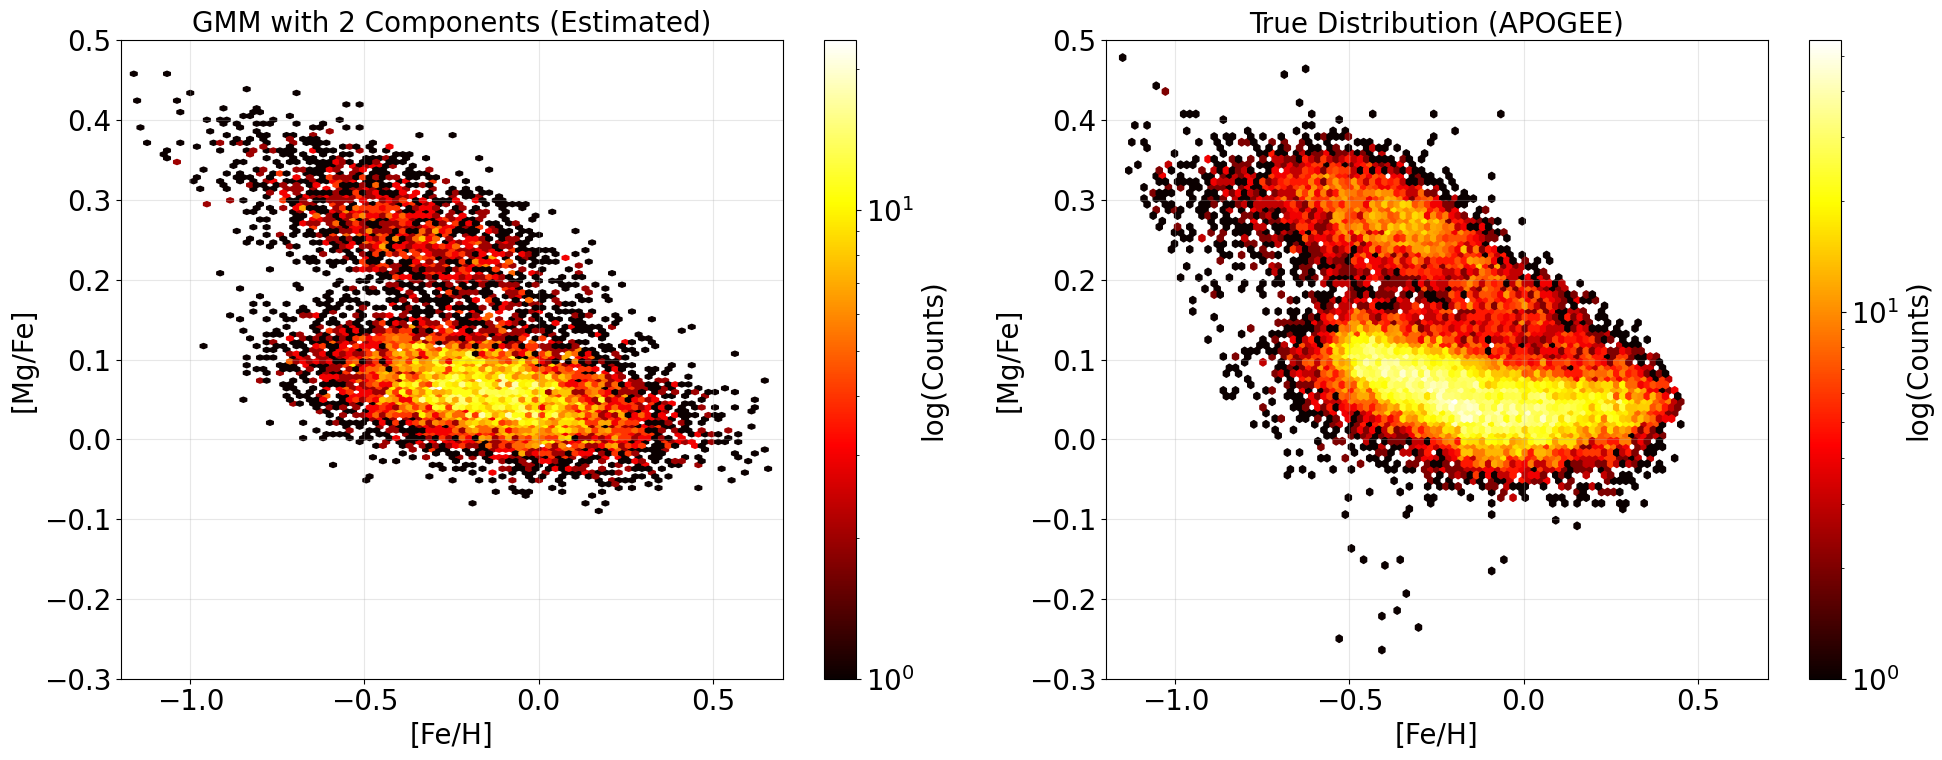

In [16]:
# The best fit mixture model
# Sampling from the first Gaussian with its corresponding weight
normal_pred = torch.distributions.multivariate_normal.MultivariateNormal(
    loc=mu1, covariance_matrix=M1@M1.T)
x_test1 = normal_pred.sample(sample_shape=torch.Size([int(10000*w1)]))

# Sampling from the second Gaussian with its corresponding weight
normal_pred = torch.distributions.multivariate_normal.MultivariateNormal(
    loc=mu2, covariance_matrix=M2@M2.T)
x_test2 = normal_pred.sample(sample_shape=torch.Size([int(10000*(1-w1))]))

# Stacking the samples from both Gaussians
x_test = torch.vstack([x_test1,x_test2])

# Plotting the estimated mixture model
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.hexbin(x_test[:,0].detach().numpy(), x_test[:,1].detach().numpy(), 
           bins='log', cmap="hot", gridsize=100, mincnt=1)
plt.colorbar(label='log(Counts)')
plt.ylim([-0.3,0.5])
plt.xlim([-1.2,0.7])
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
plt.title("GMM with 2 Components (Estimated)")
plt.grid(True, alpha=0.3)

# Plotting the ground truth distribution
plt.subplot(1, 2, 2)
plt.hexbin(x_2d[:,0].numpy(), x_2d[:,1].numpy(), 
           bins='log', cmap="hot", gridsize=100, mincnt=1)
plt.colorbar(label='log(Counts)')
plt.ylim([-0.3,0.5])
plt.xlim([-1.2,0.7])
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
plt.title("True Distribution (APOGEE)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The Gaussian mixture model provides a better approximation than a single Gaussian, capturing some of the bimodal structure. However, it still fails to represent the curved boundaries and continuous transitions between populations. Adding more Gaussian components might marginally improve the fit, but this approach faces fundamental limitations:

1. **Model complexity**: Each additional Gaussian adds 5 parameters in 2D (2 for mean, 3 for covariance, minus 1 for weight constraint), quickly leading to overparameterization.

2. **Sharp boundaries**: Gaussian mixtures create artificial boundaries between components, missing the smooth transitions in real stellar populations.

3. **Dimensionality curse**: The APOGEE survey measures abundances for many chemical elements simultaneously. In the full 13-dimensional space, parametric approaches become increasingly inadequate as the number of parameters grows exponentially with dimension.

These limitations motivate us to seek a fundamentally different approach—one that can learn arbitrary distributions without assuming specific parametric forms. This is where normalizing flows enter the picture.

## The Basic Ideas of Normalizing Flows

The traditional method of parametric maximum likelihood estimation requires prior knowledge of the parametric form of the distribution that describes the data. However, as we've seen with the APOGEE chemical abundances, there is often no good parametric form that adequately captures real astronomical distributions.

Normalizing flows offer an alternative approach that allows us to describe arbitrary distributions $p(\mathbf{x})$ without specifying their parametric form. The key insight is to learn an invertible transformation that maps our complex target distribution to a simple base distribution (typically a standard Gaussian). Instead of directly modeling $p(\mathbf{x})$, we model the transformation itself.

The fundamental idea is to find a function that performs a change of variables:

$$f: \mathbf{x} \mapsto \mathbf{z}$$

such that $p(\mathbf{z})$ is a simple distribution like a standard Gaussian. If we can learn this transformation and its inverse, we gain two powerful capabilities: we can evaluate the exact likelihood of any data point, and we can generate new samples from our complex distribution by first sampling from the simple base distribution and then applying the inverse transformation.

To illustrate this concept concretely, let's start with a simple example. We'll transform samples from a standard Gaussian distribution using a nonlinear function and observe how the distribution changes:

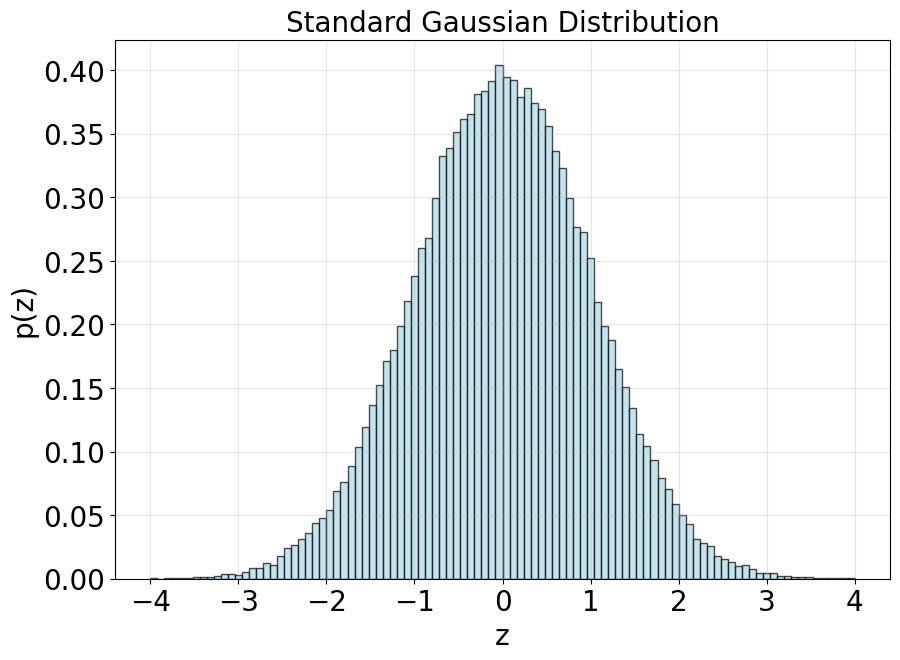

In [17]:
# Create a normal distribution with mean 0 and standard deviation 1
normal_distribution = torch.distributions.normal.Normal(loc=0, scale=1)

# Draw 10^5 samples from the distribution
z_torch = normal_distribution.sample(sample_shape=torch.Size([10**5]))

# Plot the histogram of the samples
plt.figure(figsize=(10, 7))
plt.hist(z_torch.numpy(), bins=100, range=[-4,4], density=True, 
         alpha=0.7, color='lightblue', edgecolor='black')
plt.xlabel("z")
plt.ylabel("p(z)")
plt.title("Standard Gaussian Distribution")
plt.grid(True, alpha=0.3)
plt.show()

Next, we apply a sigmoid transformation to each sample to create a more complex distribution. The transformation function:

$$g(z) = \frac{e^{3z}}{e^{3z}+1}$$

maps each $z$ value to an $x$ value between 0 and 1. This nonlinear transformation warps the Gaussian distribution into a new shape:

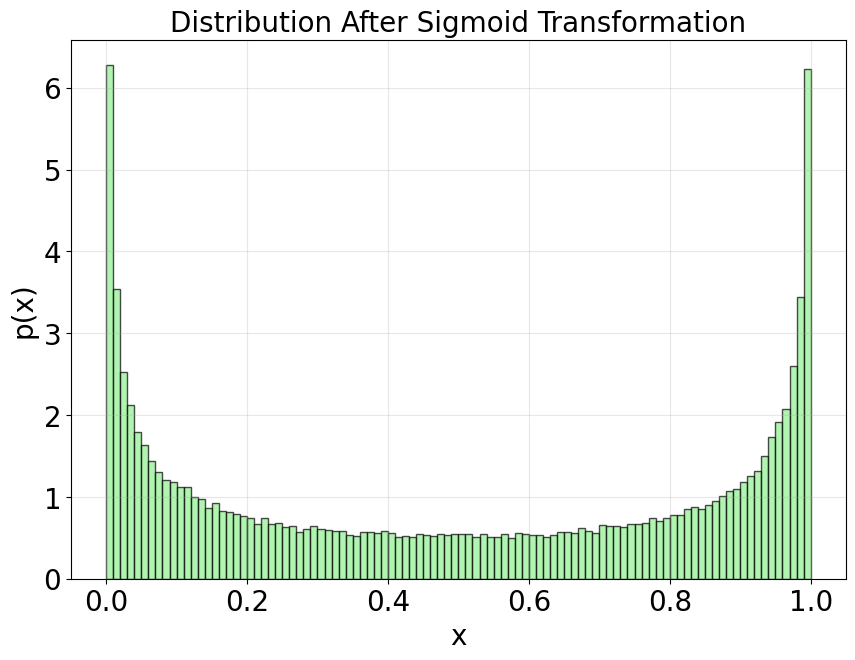

In [18]:
# Transform the variable z to x using sigmoid function
x_torch = torch.sigmoid(3*z_torch)

# Plot the histogram of the transformed variable x
plt.figure(figsize=(10, 7))
plt.hist(x_torch.numpy(), bins=100, density=True, 
         alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel("x")
plt.ylabel("p(x)")
plt.title("Distribution After Sigmoid Transformation")
plt.grid(True, alpha=0.3)
plt.show()

The transformed distribution shows interesting structure—it's bimodal with peaks near 0 and 1, very different from our original Gaussian. The key insight is that this transformation is invertible. Given only samples from the complex distribution $p(x)$, we can recover the simple Gaussian by applying the inverse transformation:

$$z = g^{-1}(x) = \frac{1}{3} \log \frac{x}{1-x}$$

This is the logit function scaled by 1/3. By applying this inverse transformation, we can map our complex samples back to the standard Gaussian:

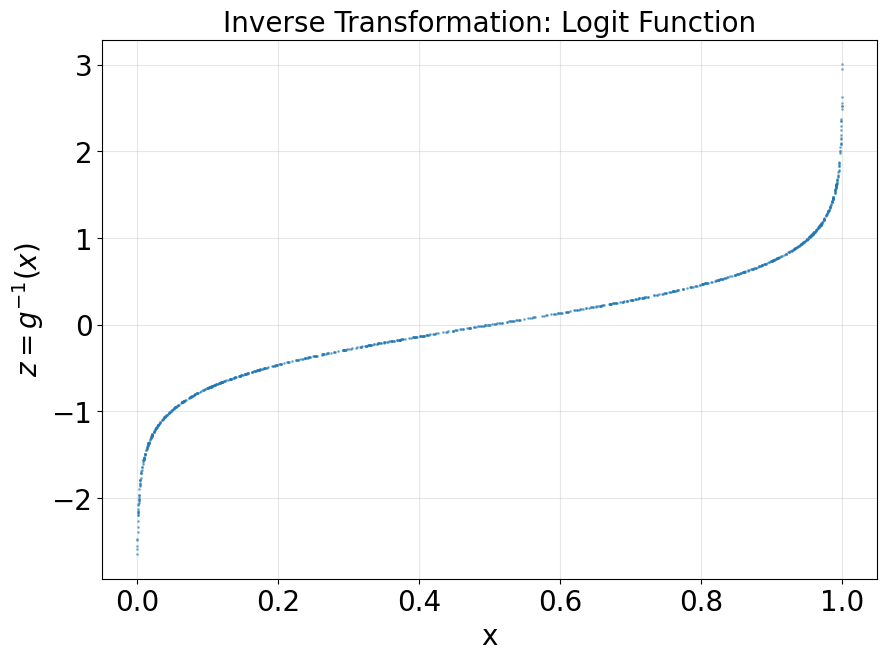

In [19]:
# Calculate the inverse function of x using the logit function
x_inverse = torch.logit(x_torch)/3.

# Plot the relationship between x and its inverse function z
plt.figure(figsize=(10, 7))
plt.scatter(x_torch[::100], x_inverse[::100], alpha=0.5, s=1)
plt.xlabel("x")
plt.ylabel(r"$z = g^{-1}(x)$")
plt.title("Inverse Transformation: Logit Function")
plt.grid(True, alpha=0.3)
plt.show()

When we apply this inverse transformation to our complex distribution, we should recover our original Gaussian distribution:

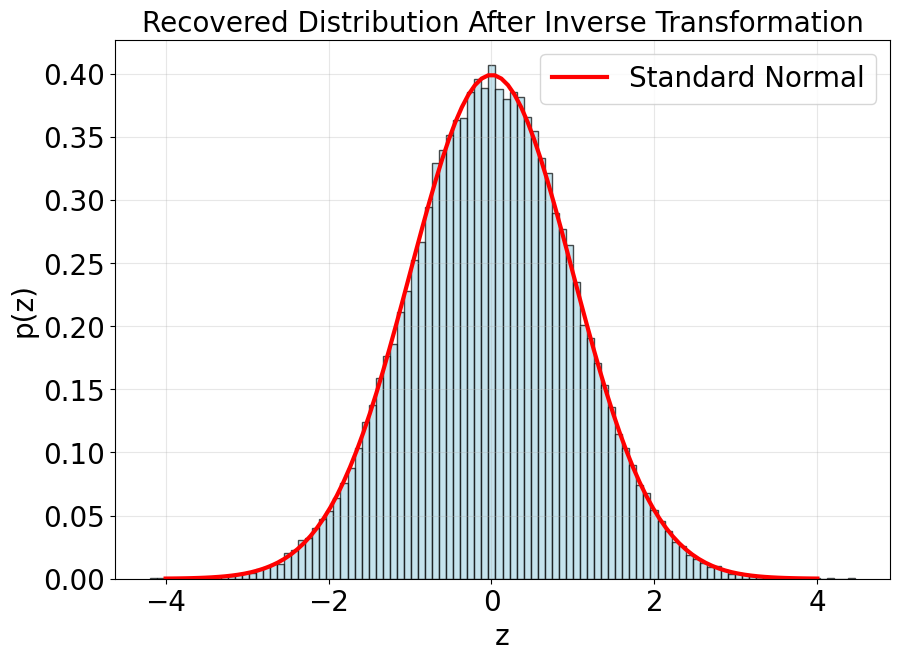

In [20]:
# Plot the histogram of z
plt.figure(figsize=(10, 7))
plt.hist(x_inverse.numpy(), bins=100, density=True,
         alpha=0.7, color='lightblue', edgecolor='black')

# Overlay the standard normal distribution
z_range = torch.linspace(-4, 4, 100)
normal_pdf = torch.exp(normal_distribution.log_prob(z_range))
plt.plot(z_range, normal_pdf, 'r-', linewidth=3, label='Standard Normal')

plt.xlabel("z")
plt.ylabel("p(z)")
plt.title("Recovered Distribution After Inverse Transformation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Success! The inverse transformation perfectly recovers our standard Gaussian distribution. This example demonstrates the core principle of normalizing flows: complex distributions can be understood through their relationship to simple ones via invertible transformations.

However, a critical question remains: how do we evaluate the likelihood $p(\mathbf{x})$ when we only know $p(\mathbf{z})$ and the transformation $f$? The answer comes from the change of variables formula in probability theory. When we transform a random variable through an invertible function, the probability density changes according to:

$$p(\mathbf{x}) = p(\mathbf{z})\left|\det\left(\frac{\partial \mathbf{z}}{\partial \mathbf{x}}\right)\right| = p(f(\mathbf{x}))\left|\det\left(\frac{\partial f}{\partial \mathbf{x}}\right)\right|$$

The determinant of the Jacobian matrix $\left|\det\left(\frac{\partial f}{\partial \mathbf{x}}\right)\right|$ accounts for how the transformation stretches or compresses space. Regions that are compressed by the transformation must have higher density to conserve probability mass.

While we successfully transformed between distributions in our simple example, this approach has a fundamental limitation: we assumed we knew the analytical form of the transformation. For the APOGEE data, what transformation would map the complex chemical abundance distribution to a Gaussian? There's no obvious analytical function that could accomplish this.

This is where neural networks enter the picture. Instead of hand-crafting transformations, we can learn them from data. The challenge is that not all neural networks are suitable for this task. To use the change of variables formula, our neural network must satisfy two critical requirements:

1. **Invertibility**: We must be able to transform in both directions—from $\mathbf{x}$ to $\mathbf{z}$ for density evaluation, and from $\mathbf{z}$ to $\mathbf{x}$ for sampling.

2. **Tractable Jacobian**: We must be able to efficiently compute the determinant of the Jacobian matrix for the likelihood calculation.

These constraints severely limit the architectures we can use. Standard feed-forward networks are generally not invertible, and even when they are, computing the Jacobian determinant for high-dimensional transformations is computationally prohibitive. This led to the development of specialized architectures designed specifically for normalizing flows.

## Introducing RealNVP

The challenge of designing invertible neural networks with tractable Jacobians led to several breakthrough architectures. Among these, RealNVP (Real-valued Non-Volume Preserving) stands out for its elegant simplicity and effectiveness. Introduced by Dinh et al. in 2016, RealNVP achieves both invertibility and efficient Jacobian computation through a clever coupling strategy.

The key insight of RealNVP is to design transformations that are trivially invertible by construction. Instead of transforming all dimensions simultaneously—which would create complex dependencies—RealNVP splits the input into two parts and transforms only one part based on the other. This coupling approach ensures that we can always invert the transformation by reversing the operations.

While more sophisticated normalizing flow architectures have been developed since RealNVP—including Masked Autoregressive Flows (MAF), Glow, and Neural Spline Flows—RealNVP provides an ideal starting point for understanding the core principles. Its relative simplicity allows us to implement it from scratch while still demonstrating the practical application of normalizing flows to astronomical data.

## Building a RealNVP from Scratch

Before diving into the mathematical details, let's understand the key design principles that make RealNVP both invertible and computationally efficient:

**Why RealNVP is Invertible:**
1. **Coupling Structure**: We split dimensions into two groups—one group remains unchanged while the other is transformed
2. **Algebraic Invertibility**: The transformation of the second group is a simple scaling and shifting that can be algebraically inverted
3. **No Neural Network Inversion**: The neural networks $s$ and $t$ are only evaluated, never inverted

**Why the Jacobian is Tractable:**
1. **Block Triangular Structure**: By keeping some dimensions fixed, the Jacobian matrix becomes triangular
2. **Diagonal Determinant**: For triangular matrices, the determinant is simply the product of diagonal elements
3. **Efficient Computation**: This reduces an $O(D^3)$ operation to $O(D)$

With these principles in mind, let's implement the transformation. For a $D$-dimensional input $\mathbf{x}$, we divide it into two parts: the first $d$ dimensions remain unchanged, while the remaining $D-d$ dimensions are transformed based on the first $d$ dimensions.

Mathematically, the forward transformation is defined as:

$$\mathbf{z}_{1:d} = \mathbf{x}_{1:d}$$

$$\mathbf{z}_{d+1:D} = \mathbf{x}_{d+1:D} \odot \exp(s(\mathbf{x}_{1:d})) + t(\mathbf{x}_{1:d})$$

where:
- The subscripts indicate dimension subsets (e.g., $\mathbf{x}_{1:d}$ represents the first $d$ dimensions)
- $\odot$ denotes element-wise multiplication
- $s$ and $t$ are neural networks that map from $\mathbb{R}^d$ to $\mathbb{R}^{D-d}$

The first equation represents an identity mapping—the first $d$ dimensions pass through unchanged. The second equation scales and shifts the remaining dimensions based on functions of the frozen dimensions. The exponential ensures that the scaling is always positive, which maintains invertibility.

Let's implement the neural networks $s$ and $t$ that form the core of our RealNVP transformation. We'll use standard Multi-Layer Perceptrons (MLPs) with ReLU activations:

In [21]:
class model(nn.Module):
    def __init__(self, num_inputs, num_hiddens):
        super(model, self).__init__()

        # Define an MLP network
        self.mlp = torch.nn.Sequential(
            # First layer: linear transformation
            torch.nn.Linear(num_inputs, num_hiddens),  # wx + b
            # Activation function
            torch.nn.ReLU(), 
            # Second layer: linear transformation
            torch.nn.Linear(num_hiddens, num_hiddens),
            # Activation function
            torch.nn.ReLU(),
            # Third layer: linear transformation
            torch.nn.Linear(num_hiddens, num_inputs),
        )
        
    def forward(self, x):
        # Apply MLP to input
        return self.mlp(x)
    
# Initialize two MLPs, s and t
num_inputs = 5
num_hiddens = 64

s_network = model(num_inputs, num_hiddens)
t_network = model(num_inputs, num_hiddens)

The MLP networks are designed more generally than our mathematical description suggests. They map from $\mathbb{R}^D$ to $\mathbb{R}^D$ rather than explicitly segregating the frozen and transformed dimensions. To implement the coupling structure, we'll use binary masks that select which dimensions to freeze and which to transform.

Consider an example with $D=5$ dimensions where we freeze the first $d=2$ dimensions. We can implement this using element-wise operations with appropriate masking:

In [22]:
# Define the mask
mask = torch.tensor([1, 1, 0, 0, 0])
inverse_mask = 1 - mask

# Generate a five-dimensional input
x_test = torch.randn(5)

# Apply the mask to the input
x_ = x_test * mask
print("Masked input (first d dimensions):", x_)

# Feed the masked input to the s_network MLP
s_output = s_network(x_)

# Apply the inverse mask to the output
s_output_ = s_output * inverse_mask
print("Masked output (last D-d dimensions):", s_output_)

Masked input (first d dimensions): tensor([-0.8084,  0.0598,  0.0000,  0.0000,  0.0000])
Masked output (last D-d dimensions): tensor([-0.0000, -0.0000, -0.1002, -0.0784,  0.1414], grad_fn=<MulBackward0>)


The masking strategy elegantly implements our mathematical description. When we multiply the input by `mask`, we zero out the last three dimensions, keeping only the first two. The MLP processes this masked input, effectively learning a function of only the first two dimensions since the others are always zero. By applying `inverse_mask` to the output, we extract only the transformed dimensions while zeroing out the dimensions that should remain frozen.

This approach allows us to use a single MLP architecture that maps $\mathbb{R}^D \to \mathbb{R}^D$ while effectively implementing the required $\mathbb{R}^d \to \mathbb{R}^{D-d}$ mapping through masking. Let's now see how to combine the $s$ and $t$ networks to perform the complete RealNVP transformation:

In [23]:
x_ = x_test * mask
s = s_network(x_) * inverse_mask
t = t_network(x_) * inverse_mask

print("s(x_{1:d}):", s)
print("t(x_{1:d}):", t)

# Apply the transformation: z = x_{1:d} + (x_{d+1:D} * exp(s) + t)
z_ = (x_test * inverse_mask) * torch.exp(s) + t
print("Transformed dimensions z_{d+1:D}:", z_)

s(x_{1:d}): tensor([-0.0000, -0.0000, -0.1002, -0.0784,  0.1414], grad_fn=<MulBackward0>)
t(x_{1:d}): tensor([-0.0000,  0.0000, -0.1170,  0.0919, -0.0533], grad_fn=<MulBackward0>)
Transformed dimensions z_{d+1:D}: tensor([-0.0000,  0.0000, -0.0172,  2.1878,  1.0599], grad_fn=<AddBackward0>)


To complete the RealNVP transformation, we need to concatenate the frozen dimensions with the transformed dimensions. Since our masks ensure non-overlapping dimension sets, we can simply add them together:

In [24]:
# Print out the values of z_ and x_
print("Transformed dimensions z_{d+1:D}:", z_)
print("Frozen dimensions x_{1:d}:", x_)

# Sum them up to concatenate the transformed and frozen dimensions
z = z_ + x_
print("Complete output z:", z)

Transformed dimensions z_{d+1:D}: tensor([-0.0000,  0.0000, -0.0172,  2.1878,  1.0599], grad_fn=<AddBackward0>)
Frozen dimensions x_{1:d}: tensor([-0.8084,  0.0598,  0.0000,  0.0000,  0.0000])
Complete output z: tensor([-0.8084,  0.0598, -0.0172,  2.1878,  1.0599], grad_fn=<AddBackward0>)


To summarize, the implementation of a single-layer RealNVP transformation can be elegantly expressed in just a few lines of code:

In [25]:
def f(x, mask):
    inverse_mask = 1 - mask
    x_ = x * mask
    s = s(x_) * inverse_mask
    t = t(x_) * inverse_mask
    z = x_ + (x*inverse_mask * torch.exp(s) + t)
    return z

While this implementation is straightforward, the complexity of the $s$ and $t$ MLP networks can be increased by adding more hidden layers and neurons. This allows for greater flexibility in modeling complex distributions.

The brilliance of RealNVP lies in its ability to satisfy both the invertibility and tractable Jacobian requirements with ease, as we'll explore in the following sections.

## Inverting RealNVP

A key requirement for normalizing flows is invertibility—we must be able to transform in both directions. The elegant design of RealNVP makes inversion remarkably straightforward. 

To invert the transformation, we need to find a mapping from $\mathbf{z}$ back to $\mathbf{x}$. The first $d$ dimensions are trivial to invert since they weren't transformed:

$$\mathbf{x}_{1:d} = \mathbf{z}_{1:d}$$

For the remaining dimensions, recall that the forward transformation was:

$$\mathbf{z}_{d+1:D} = \mathbf{x}_{d+1:D} \odot \exp(s(\mathbf{x}_{1:d})) + t(\mathbf{x}_{1:d})$$

To recover $\mathbf{x}_{d+1:D}$, we can algebraically rearrange this equation:

$$\mathbf{x}_{d+1:D} = (\mathbf{z}_{d+1:D} - t(\mathbf{z}_{1:d})) \odot \exp(-s(\mathbf{z}_{1:d}))$$

Notice the crucial insight: since $\mathbf{x}_{1:d} = \mathbf{z}_{1:d}$, we can evaluate $s$ and $t$ using $\mathbf{z}_{1:d}$ directly. This means we don't need to invert the neural networks themselves—we simply apply them to the unchanged dimensions and algebraically invert the affine transformation.

In [26]:
def g(z, mask):
    inverse_mask = 1 - mask
    z_ = mask * z
    s = s_network(z_) * inverse_mask
    t = t_network(z_) * inverse_mask
    x = z_ + (z*inverse_mask - t) * torch.exp(-s)
    return x

This inverse function demonstrates a fundamental advantage of the RealNVP architecture: we achieve invertibility without having to invert the neural networks $s$ and $t$. The networks are used in the same forward direction for both the forward and inverse transformations. This is possible because the coupling structure ensures that the inputs to $s$ and $t$ (the first $d$ dimensions) are preserved unchanged through the transformation.

The ability to train networks with standard forward passes and backpropagation, while automatically obtaining their inverse, makes RealNVP particularly practical. This design principle—combining neural networks with carefully structured transformations to ensure invertibility—is a hallmark of successful normalizing flow architectures.

## The Jacobian of RealNVP

Having established that RealNVP is invertible, we now turn to the second critical requirement: computing the Jacobian determinant efficiently. Recall that the change of variables formula requires:

$$\log p(\mathbf{x}) = \log p(\mathbf{z}) + \log\left|\det\left(\frac{\partial \mathbf{z}}{\partial \mathbf{x}}\right)\right|$$

For the forward RealNVP transformation:
- $\mathbf{z}_{1:d} = \mathbf{x}_{1:d}$
- $\mathbf{z}_{d+1:D} = \mathbf{x}_{d+1:D} \odot \exp(s(\mathbf{x}_{1:d})) + t(\mathbf{x}_{1:d})$

The Jacobian matrix has a special structure. When we compute the partial derivatives, we get:

$$\mathbf{J} = \frac{\partial \mathbf{z}}{\partial \mathbf{x}} = \begin{bmatrix} \mathbb{I}_{d \times d} & \mathbf{0}_{d \times (D-d)} \\ \frac{\partial \mathbf{z}_{d+1:D}}{\partial \mathbf{x}_{1:d}} & \text{diag}(\exp(s(\mathbf{x}_{1:d}))) \end{bmatrix}$$

This is a lower-triangular block matrix. The determinant of such a matrix is simply the product of its diagonal elements:

$$\det(\mathbf{J}) = \prod_{j=d+1}^{D} \exp(s(\mathbf{x}_{1:d}))_j = \exp\left(\sum_{j=d+1}^{D} s(\mathbf{x}_{1:d})_j\right)$$

This remarkable simplification is what makes RealNVP computationally efficient. Instead of computing a full matrix determinant—which scales as $O(D^3)$—we only need to sum the outputs of the $s$ network, an $O(D)$ operation.

For practical implementation, we work with log-determinants to maintain numerical stability:

$$\log|\det(\mathbf{J})| = \sum_{j=d+1}^{D} s(\mathbf{x}_{1:d})_j$$

This means we can augment our forward transformation to return both the transformed data and the log-determinant:

In [27]:
def f(x, mask):
    inverse_mask = 1 - mask
    x_ = x * mask
    s = s_network(x_) * inverse_mask
    t = t_network(x_) * inverse_mask
    z = x_ + (x*inverse_mask * torch.exp(s) + t)
    
    # Calculate the log determinant of the Jacobian
    log_det_J = s.sum(dim=1) 
    
    return z, log_det_J

## The Coupling Strategy

Our discussion so far assumes that some dimensions remain unchanged during transformation. This raises a potential concern: if certain dimensions are never transformed, how can we model complex distributions where all dimensions need to change?

The solution is elegant: we apply multiple RealNVP transformations in sequence, each time changing which dimensions are held fixed. By alternating the roles of "frozen" and "transformed" dimensions, we ensure that every dimension gets transformed while maintaining the mathematical properties that make RealNVP tractable.

Consider applying two RealNVP operations, $f_1$ and $f_2$, with complementary masks. If $f_1$ fixes dimensions 1 to $d$ and transforms dimensions $d+1$ to $D$, then $f_2$ can fix dimensions $d+1$ to $D$ and transform dimensions 1 to $d$. The composite transformation is:

$$f(\mathbf{x}) = f_2 \circ f_1(\mathbf{x})$$

Since both $f_1$ and $f_2$ are invertible, their composition is also invertible:

$$f^{-1}(\mathbf{z}) = f_1^{-1} \circ f_2^{-1}(\mathbf{z})$$

Note that we apply the inverse transformations in reverse order. This coupling strategy allows us to build arbitrarily complex transformations while maintaining computational efficiency.

The coupling strategy can be visualized as a sequence of transformations where different subsets of dimensions are alternately held fixed. In each layer:

1. **Layer 1**: Dimensions 1-d are frozen (pass through unchanged), while dimensions (d+1)-D are transformed based on dimensions 1-d
2. **Layer 2**: Dimensions (d+1)-D are frozen, while dimensions 1-d are transformed based on dimensions (d+1)-D  
3. **Layer 3**: Back to the pattern of Layer 1, and so on...

This alternating pattern ensures that every dimension gets transformed multiple times throughout the flow, while maintaining the special structure that makes inversion and Jacobian computation efficient. By stacking multiple such layers, we can express increasingly complex transformations while preserving the mathematical properties we need.

The Jacobian computation for composite transformations follows naturally from the chain rule. If we have $f = f_1 \circ f_2$, then:

$$\mathbf{J}_f = \mathbf{J}_{f_1} \cdot \mathbf{J}_{f_2}$$

Taking determinants:

$$\det(\mathbf{J}_f) = \det(\mathbf{J}_{f_1}) \cdot \det(\mathbf{J}_{f_2})$$

In log space, this becomes a simple addition:

$$\log|\det(\mathbf{J}_f)| = \log|\det(\mathbf{J}_{f_1})| + \log|\det(\mathbf{J}_{f_2})|$$

This additive property means that when we compose multiple RealNVP layers, we simply sum their individual log-determinants. This maintains the computational efficiency of the approach—each layer contributes one easily-computed term to the total.

With these building blocks in place, we can now implement a complete RealNVP model that learns to transform complex distributions.

## A Concise Implementation of RealNVP in PyTorch

We now implement RealNVP to model the APOGEE chemical abundance distribution. The power of normalizing flows lies in their ability to handle high-dimensional distributions without imposing parametric assumptions. We'll train our model on the full 13-dimensional chemical abundance space and visualize results through familiar 2D projections.

For this astronomical application, we follow the approach first introduced by [Ting & Weinberg (2022)](https://ui.adsabs.harvard.edu/abs/2022ApJ...927..209T/abstract), who demonstrated how normalizing flows can capture the complex structure of stellar chemical abundance distributions, enabling precise characterization of the Milky Way's chemical evolution.

Let's begin by loading the full APOGEE dataset with all available chemical abundances:

In [28]:
# Load the preprocessed abundances
data = np.load('dataset_apogee_abundances.npz')

# Stack all abundances into a single array
abundances = []
abundance_names = []
for key in ['mgh', 'oh', 'sih', 'sh', 'cah', 'nah', 'alh', 
            'kh', 'crh', 'feh', 'nih', 'vh', 'coh']:
    abundances.append(data[key])
    abundance_names.append(key)

x_numpy = np.column_stack(abundances)
x_torch = torch.tensor(x_numpy, dtype=torch.float32)

print(f"Data shape: {x_torch.shape}")
print(f"Number of stars: {x_torch.shape[0]}")
print(f"Number of abundances: {x_torch.shape[1]}")
print(f"Abundances: {abundance_names}")

# Get the number of input dimensions
num_inputs = x_torch.shape[1]

Data shape: torch.Size([23986, 13])
Number of stars: 23986
Number of abundances: 13
Abundances: ['mgh', 'oh', 'sih', 'sh', 'cah', 'nah', 'alh', 'kh', 'crh', 'feh', 'nih', 'vh', 'coh']


To implement RealNVP, we need to create multiple transformation blocks with different masking patterns. Each block will transform a different subset of dimensions, ensuring that all dimensions are eventually transformed:

In [29]:
# Number of RealNVP blocks
num_blocks = 8

# Creating masks for each of the 8 blocks
# Randomly assign 0 or 1 to each dimension for each block
masks = torch.tensor(
    np.array([np.random.randint(2, size=(num_inputs)) 
              for i in range(num_blocks)]), 
    dtype=torch.float32
)

print(f"Number of blocks: {num_blocks}")
print(f"Mask shape: {masks.shape}")
print(f"Example mask (block 0): {masks[0]}")

Number of blocks: 8
Mask shape: torch.Size([8, 13])
Example mask (block 0): tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])


Next, we define our target distribution—a multivariate standard Gaussian in 13 dimensions. This will serve as our base distribution that we transform into the complex APOGEE abundance distribution:

In [30]:
prior = torch.distributions.MultivariateNormal(
    loc=torch.zeros(num_inputs),
    covariance_matrix=torch.eye(num_inputs)
)

print(f"Prior distribution: {num_inputs}-dimensional standard Gaussian")

Prior distribution: 13-dimensional standard Gaussian


Now we'll define the MLP networks for the $s$ and $t$ transformations. We need a pair of networks for each RealNVP block:

In [31]:
# Define a class called model which extends nn.Module
class model(nn.Module):
    
    # Constructor to define the layers of the MLP network
    def __init__(self, num_inputs, num_hiddens):
        
        # Calling the parent constructor
        super(model, self).__init__()
        
        # Define the layers of the MLP network
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(num_inputs, num_hiddens),
            torch.nn.ReLU(), 
            torch.nn.Linear(num_hiddens, num_hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(num_hiddens, num_hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(num_hiddens, num_inputs),
        )
    
    # Forward function which performs forward pass on the MLP network
    def forward(self, x):
        return self.mlp(x)
    

# Define the number of hidden neurons to be 64 for each hidden layer
num_hiddens = 64

# Create a list of MLP networks for the s network using the model class
nets = torch.nn.ModuleList([model(num_inputs, num_hiddens) for _ in range(len(masks))])

# Create a list of MLP networks for the t network using the model class
nett = torch.nn.ModuleList([model(num_inputs, num_hiddens) for _ in range(len(masks))])

Now we can implement the complete RealNVP normalizing flow by combining all our components:

In [32]:
# Define our normalizing flow
class RealNVP(nn.Module):
    
    # Initiate the model
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        
        # Set mask as parameter but without requiring gradient
        self.mask = nn.Parameter(mask, requires_grad=False) 
        
        # Assign neural networks for transformation
        self.t = nett
        self.s = nets

    # Forward transformation (x->z)
    def f(self, x):
        
        # Empty array to store the final Jacobian, evaluated at individual points
        log_det_J = torch.zeros(x.shape[0])
        
        # Apply transformation blocks successively (with a for loop)
        for i in range(len(self.t)):
            
            # Create inverse mask, and mask the input x
            inverse_mask = 1 - self.mask[i]
            x_ = x * self.mask[i]
            
            # Apply the two MLP networks s and t to the masked input x
            s = self.s[i](x_) * inverse_mask
            t = self.t[i](x_) * inverse_mask
            
            # Apply the affine transformation
            x = x_ + (x * inverse_mask * torch.exp(s) + t) 
            
            # Compute the log Jacobian and sum it up
            log_det_J += torch.sum(s, axis=1)
            
        # Return transformed input x and its final Jacobian determinant
        return x, log_det_J

    # Inverse transformation (z->x)
    def g(self, z):
        
        # Apply the inverse transformation by iterating through the transformation blocks in reverse
        for i in reversed(range(len(self.t))):
            inverse_mask = 1 - self.mask[i]
            z_ = self.mask[i] * z
            s = self.s[i](z_) * inverse_mask
            t = self.t[i](z_) * inverse_mask
            
            # Apply the inverse affine transformation
            z = (z * inverse_mask - t) * torch.exp(-s) + z_
        
        # Return the inverse transformed z
        return z
    
    # Compute the log probability using the normalizing flow
    def log_prob(self, x):
        z, log_det_J = self.f(x)
        return self.prior.log_prob(z) + log_det_J


# Create the normalizing flow instance
flow = RealNVP(nets, nett, masks, prior)

# Print the total number of parameters in the normalizing flow
print("We are training a deep learning model with",
      sum(p.numel() for p in flow.parameters()),
      "parameters.")

We are training a deep learning model with 161080 parameters.


Now we can train our RealNVP model using standard stochastic gradient descent with mini-batches:

In [33]:
num_epochs = 1000
batch_size = 2048

# We will optimize all parameters in the 2 x n_blocks s and t MLP networks
optimiser = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)

# Load data into dataloader to facilitate batch training
train_loader = DataLoader(x_torch, batch_size, shuffle=True)

# Train our normalizing flow for num_epochs epochs
for e in range(num_epochs):

    # Iterate through the training data by batch
    for data in train_loader:
        loss = -flow.log_prob(data).mean()  # Compute the negative log likelihood loss
        optimiser.zero_grad()  # Set gradients to zero
        loss.backward(retain_graph=True)  # Compute gradients
        optimiser.step()  # Update parameters
        
    # Print out loss every 100 epochs
    if e % 100 == 0:
        print('iter %s:' % e, 'loss = %.3f' % loss)

# Save the trained model to disk
torch.save(flow.state_dict(), 'trained_realnvp.pth')
print("\nModel saved to trained_realnvp.pth")

iter 0: loss = 12.305
iter 100: loss = -21.718
iter 200: loss = -22.330
iter 300: loss = -22.451
iter 400: loss = -22.907
iter 500: loss = -22.875
iter 600: loss = -23.173
iter 700: loss = -23.077
iter 800: loss = -23.004
iter 900: loss = -23.372

Model saved to trained_realnvp.pth


After training, we can load our saved model and use it to generate new samples from the learned distribution:

In [34]:
# Load the trained model
state_dict = torch.load('trained_realnvp.pth')
flow.load_state_dict(state_dict)
flow.eval()  # Set to evaluation mode

print("Model loaded successfully")

Model loaded successfully


Now we can use our trained model to generate new samples and visualize how well it has learned the APOGEE abundance distribution. We'll sample from the prior Gaussian distribution and transform through the inverse flow:

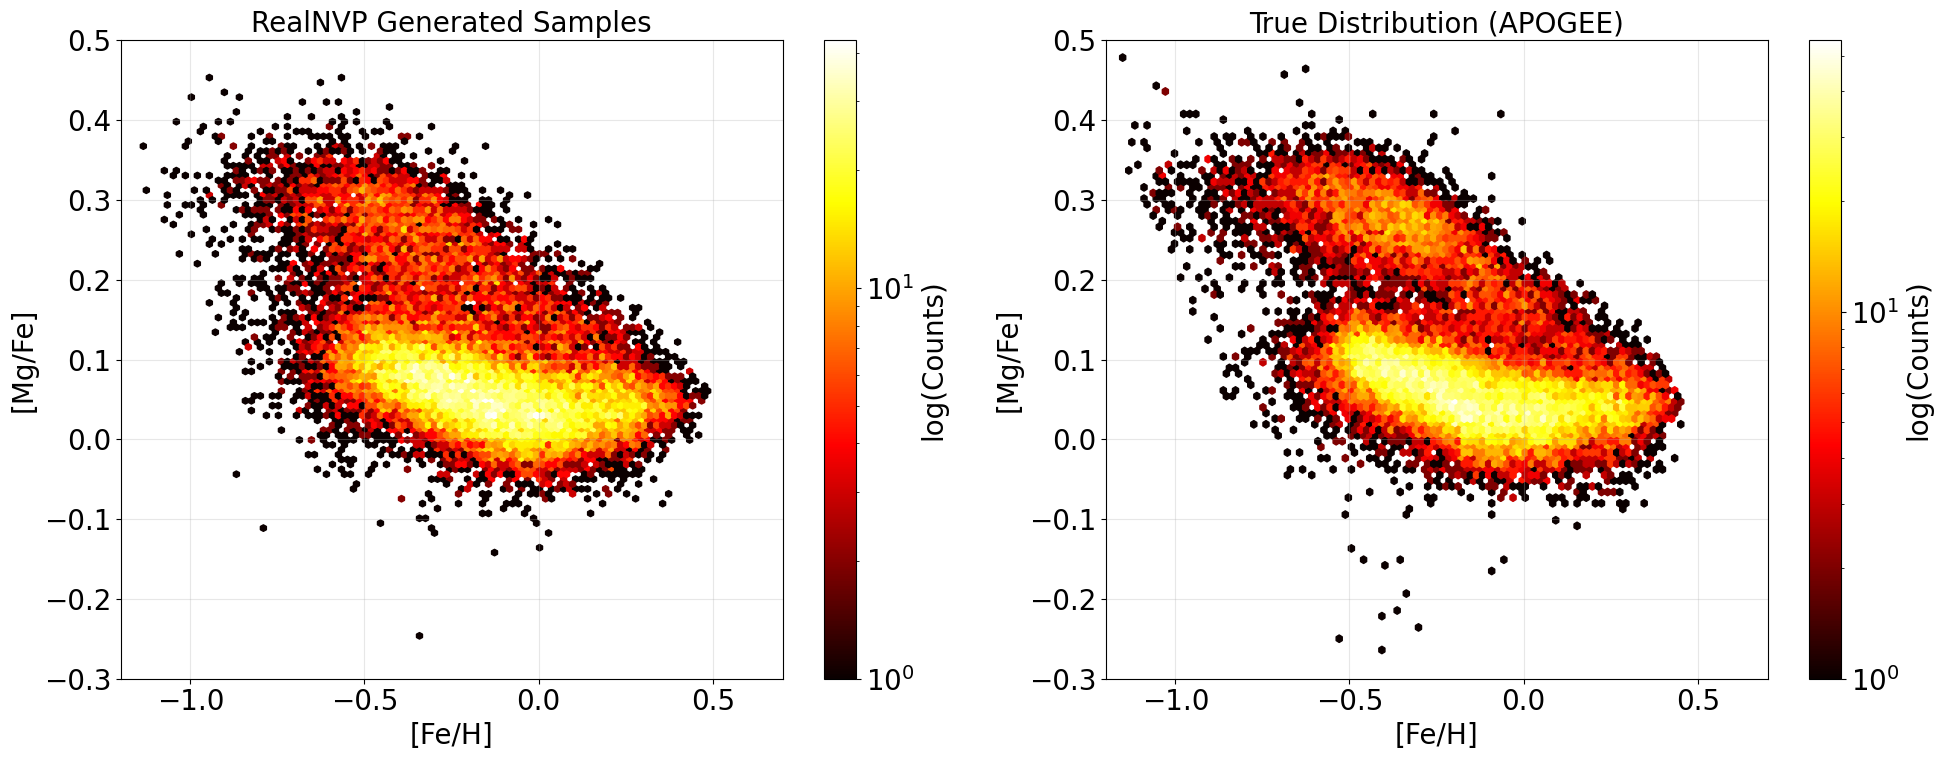

In [35]:
# Draw samples from p(z) with the same size as the training data
z_torch = prior.sample(sample_shape=torch.Size([x_torch.shape[0]]))

# Use the inverse transformation to transform the samples to p(x)
x_test = flow.g(z_torch)

# Calculate [Mg/Fe] from the generated samples
# Find indices for Mg/H and Fe/H
mgh_idx = abundance_names.index('mgh')
feh_idx = abundance_names.index('feh')

# Plot the estimated and ground truth distributions
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.hexbin(x_test[:, feh_idx].detach().numpy(), 
           x_test[:, mgh_idx].detach().numpy() - x_test[:, feh_idx].detach().numpy(),
           bins='log', cmap="hot", gridsize=100, mincnt=1)
plt.colorbar(label='log(Counts)')
plt.ylim([-0.3, 0.5])
plt.xlim([-1.2, 0.7])
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
plt.title("RealNVP Generated Samples")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hexbin(x_torch[:, feh_idx].numpy(), 
           x_torch[:, mgh_idx].numpy() - x_torch[:, feh_idx].numpy(),
           bins='log', cmap="hot", gridsize=100, mincnt=1)
plt.colorbar(label='log(Counts)')
plt.ylim([-0.3, 0.5])
plt.xlim([-1.2, 0.7])
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
plt.title("True Distribution (APOGEE)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The RealNVP model captures the overall structure of the APOGEE distribution, including the bimodal nature and general shape of the stellar populations. This is particularly remarkable given that we trained on the full 13-dimensional chemical abundance space simultaneously, not just the 2D projection we visualized.

To demonstrate how the model performs across all dimensions, let's examine the learned distributions for different elemental abundances. By visualizing [X/Fe] versus [Fe/H] for each element, we can assess whether the model correctly captures the correlations and structures present in various chemical dimensions:

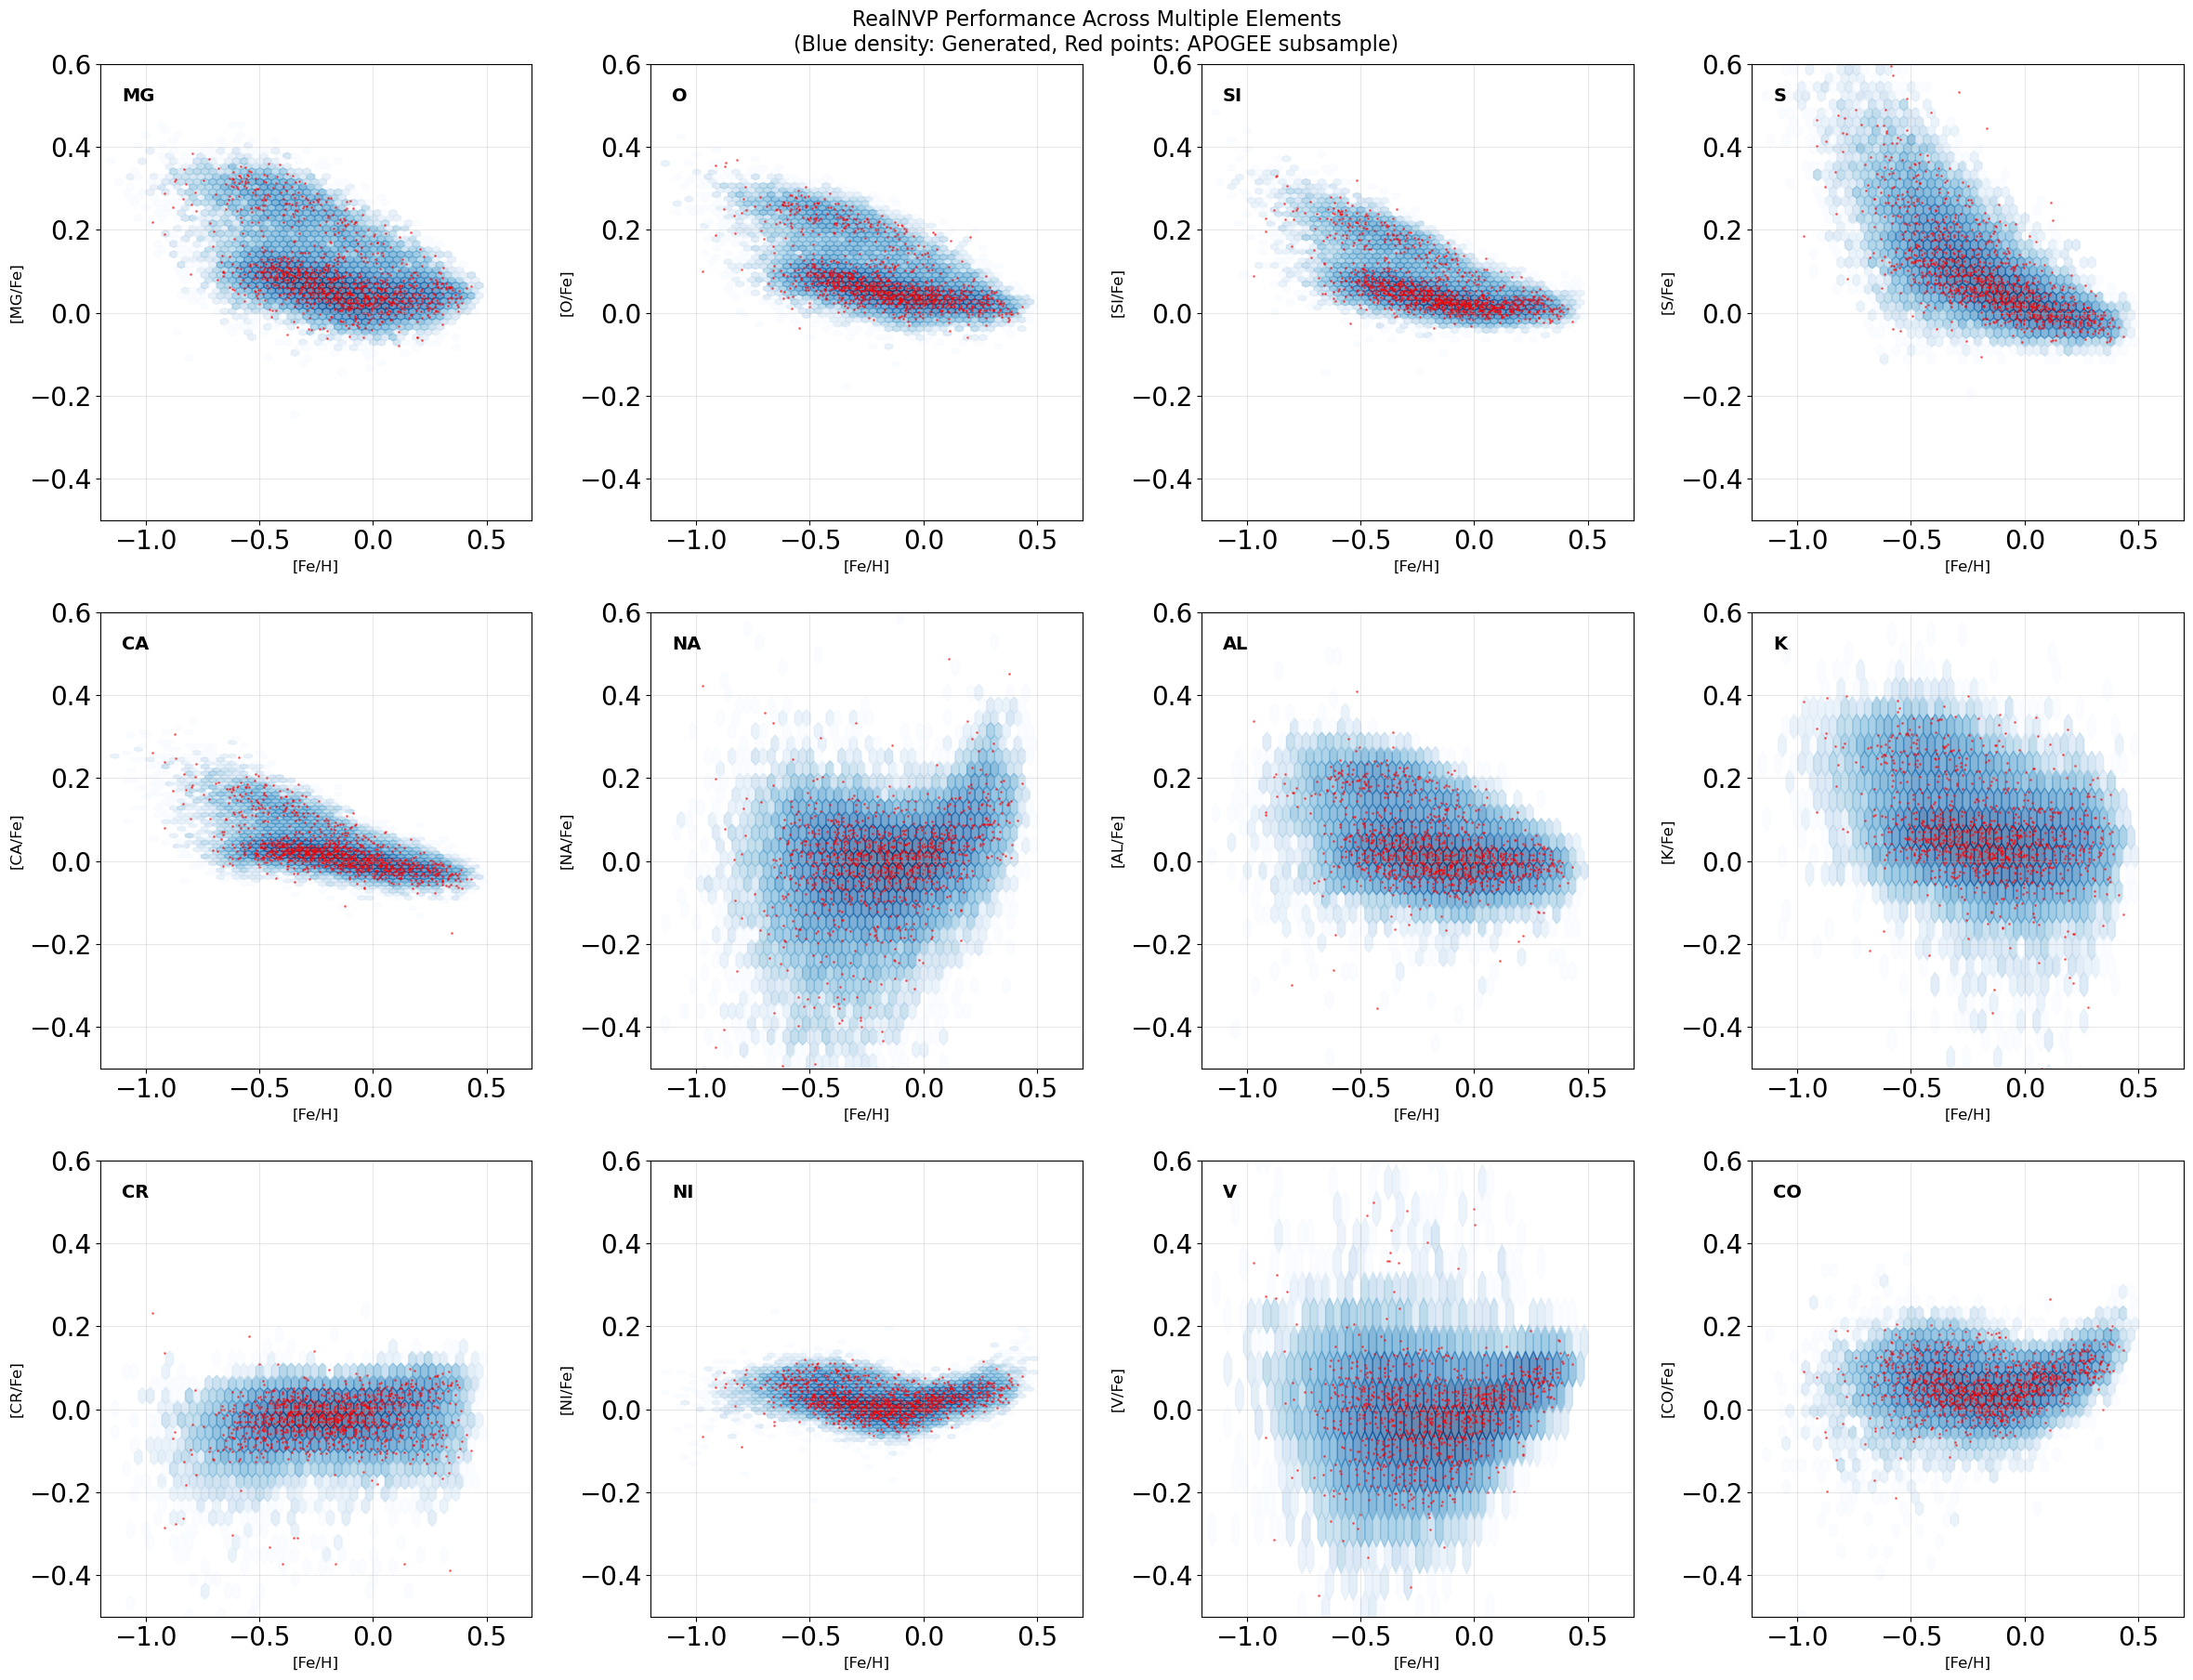

In [36]:
# Create a figure to show multiple [X/Fe] vs [Fe/H] distributions
fig, axes = plt.subplots(3, 4, figsize=(24, 18))
axes = axes.flatten()

# Elements to plot (excluding Fe itself)
elements = ['mgh', 'oh', 'sih', 'sh', 'cah', 'nah', 'alh', 'kh', 'crh', 'nih', 'vh', 'coh']

# Randomly sample points for scatter plot to avoid overcrowding
sample_indices = np.random.choice(len(x_torch), size=1000, replace=False)

for idx, element in enumerate(elements):
    if idx >= 12:  # We only have 12 subplots
        break
        
    ax = axes[idx]
    elem_idx = abundance_names.index(element)
    
    # Plot generated samples as hexbin with higher resolution
    ax.hexbin(x_test[:, feh_idx].detach().numpy(), 
              x_test[:, elem_idx].detach().numpy() - x_test[:, feh_idx].detach().numpy(),
              bins='log', cmap="Blues", gridsize=50, mincnt=1, alpha=0.6)
    
    # Overlay true data as scatter points
    ax.scatter(x_torch[sample_indices, feh_idx].numpy(), 
               x_torch[sample_indices, elem_idx].numpy() - x_torch[sample_indices, feh_idx].numpy(),
               s=1, alpha=0.5, color='red', label='APOGEE data')
    
    ax.set_xlim([-1.2, 0.7])
    ax.set_ylim([-0.5, 0.6])
    ax.set_xlabel("[Fe/H]", fontsize=12)
    ax.set_ylabel(f"[{element.replace('h','').upper()}/Fe]", fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Add element name in corner
    ax.text(0.05, 0.95, element.replace('h','').upper(), 
            transform=ax.transAxes, fontsize=14, fontweight='bold',
            verticalalignment='top')

plt.tight_layout()
plt.suptitle("RealNVP Performance Across Multiple Elements\n(Blue density: Generated, Red points: APOGEE subsample)", 
             fontsize=16, y=1.01)
plt.show()

The visualization reveals that RealNVP successfully learns meaningful structure across multiple chemical dimensions simultaneously. For most elements, the model captures the characteristic bimodal distribution and the general correlation patterns with [Fe/H]. The generated samples (blue density) broadly follow the true data distribution (red points), demonstrating that the model has learned the complex, correlated structure of the 13-dimensional chemical abundance space.

However, some limitations are evident. The model struggles to perfectly capture sharp boundaries and fine-scale structures present in the data. For certain elements, the generated distribution appears somewhat smoother than the true distribution, missing some of the detailed substructure. These limitations arise from RealNVP's relatively simple architecture—it represents one of the earliest and most basic normalizing flow designs.

Despite these limitations, the ability to model a 13-dimensional distribution without assuming any parametric form represents a significant advance over traditional methods. Where Gaussian mixture models failed even in 2D, normalizing flows provide a principled approach to learning complex, high-dimensional distributions directly from data.

## Summary

This tutorial has demonstrated how normalizing flows, specifically RealNVP, provide a powerful framework for modeling complex astronomical distributions without parametric assumptions. Through our implementation, we've seen how these methods overcome fundamental limitations of traditional approaches:

1. **Parametric Freedom**: Unlike Gaussian mixture models that impose specific functional forms, normalizing flows learn transformations that can represent arbitrary distributions.

2. **Exact Likelihood**: The invertible design allows us to compute exact likelihoods, maintaining the statistical rigor necessary for scientific applications.

3. **Scalability**: Our model successfully learned the 13-dimensional APOGEE chemical abundance distribution, demonstrating the method's ability to handle high-dimensional data.

4. **Bidirectional Capability**: We can both evaluate the likelihood of observed data and generate new samples, enabling diverse applications from anomaly detection to synthetic data generation.

The RealNVP architecture achieves these capabilities through clever design choices: the coupling structure ensures invertibility, the masking strategy allows all dimensions to be transformed, and the triangular Jacobian structure enables efficient computation. While more sophisticated normalizing flow architectures have since been developed—offering greater expressivity and better capture of fine-scale structure—RealNVP provides an accessible entry point for understanding these powerful methods.

For astronomical applications, normalizing flows open new possibilities: characterizing complex populations in survey data, building flexible priors for Bayesian inference, and enabling simulation-based inference when analytical likelihoods are intractable. As demonstrated by [Ting & Weinberg (2022)](https://ui.adsabs.harvard.edu/abs/2022ApJ...927..209T/abstract), these methods can capture the intricate structure of chemical abundance distributions with unprecedented precision, enabling new insights into galactic chemical evolution. As we collect ever-larger astronomical datasets with increasing dimensionality, these methods will become increasingly valuable tools for extracting scientific insights from complex, high-dimensional distributions.